In [1]:
import h5py
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from toolz import keymap
from tqdm.auto import tqdm
from pathlib import Path
from aging.behavior.scalars import compute_scalars
from aging.size_norm.data import clean
from aging.plotting import figure, format_plots

In [2]:
format_plots()

In [3]:
from scipy.ndimage import gaussian_filter, shift
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

In [4]:
folder = Path('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021')
files = sorted(folder.glob('**/results_00.h5'))

In [5]:
files

[PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429093852/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429094029/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429094121/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429094215/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429104908/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429104919/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210429104926/proc/results_00.h5'),
 PosixPath('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males/18months_29042021/session_20210

In [6]:
with h5py.File(files[0], 'r') as h5f:
    frames = h5f['frames'][()]
    recon_frames = h5f['win_size_norm_frames_v4'][()]

In [7]:
clean_frames = np.array([clean(f, height_thresh=16, tail_ksize=7) for f in frames])

In [7]:
scalars = compute_scalars(clean_frames, is_recon=False, height_thresh=10)
scalars4 = compute_scalars(
    np.array([clean(f, height_thresh=15, tail_ksize=7) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
scalars5 = compute_scalars(
    np.array([clean(f, height_thresh=14, tail_ksize=7) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
scalars6 = compute_scalars(
    np.array([clean(f, height_thresh=14, tail_ksize=7, dilation_ksize=4) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
scalars2 = compute_scalars(
    np.array([clean(f, height_thresh=13, tail_ksize=7) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
scalars3 = compute_scalars(
    np.array([clean(f, height_thresh=21, tail_ksize=7, dilation_ksize=5) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
scalars_old = compute_scalars(frames, is_recon=False, height_thresh=10)
scalars_old2 = compute_scalars(
    np.array([clean(f, height_thresh=10, tail_ksize=13) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
recon_scalars = compute_scalars(recon_frames, is_recon=False, height_thresh=10)

In [27]:
cat = np.array([x['width'] for x in (scalars, scalars4, scalars5, scalars6, scalars2, scalars3, scalars_old, scalars_old2, recon_scalars)])
cat = np.nan_to_num(cat)

In [28]:
corr_dists = squareform(pdist(cat, metric='correlation'))

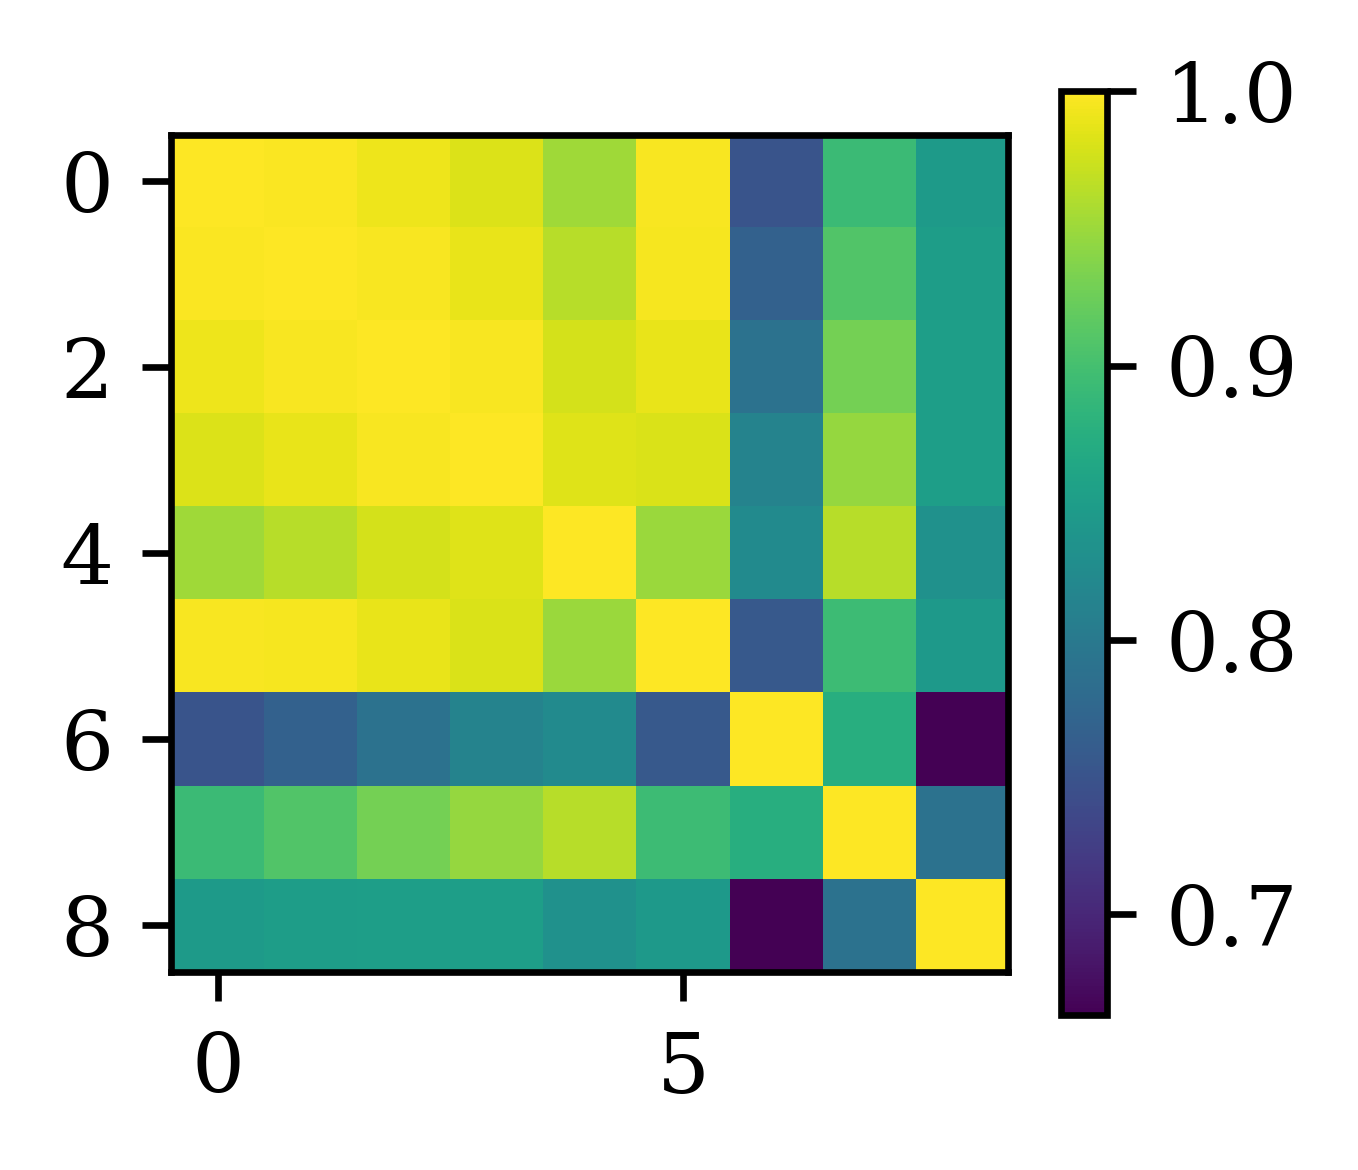

In [29]:
figure(2.25, 2)
plt.imshow(1 - corr_dists)
plt.colorbar()

In [30]:
np.argmin(corr_dists[-1, :-1])

3

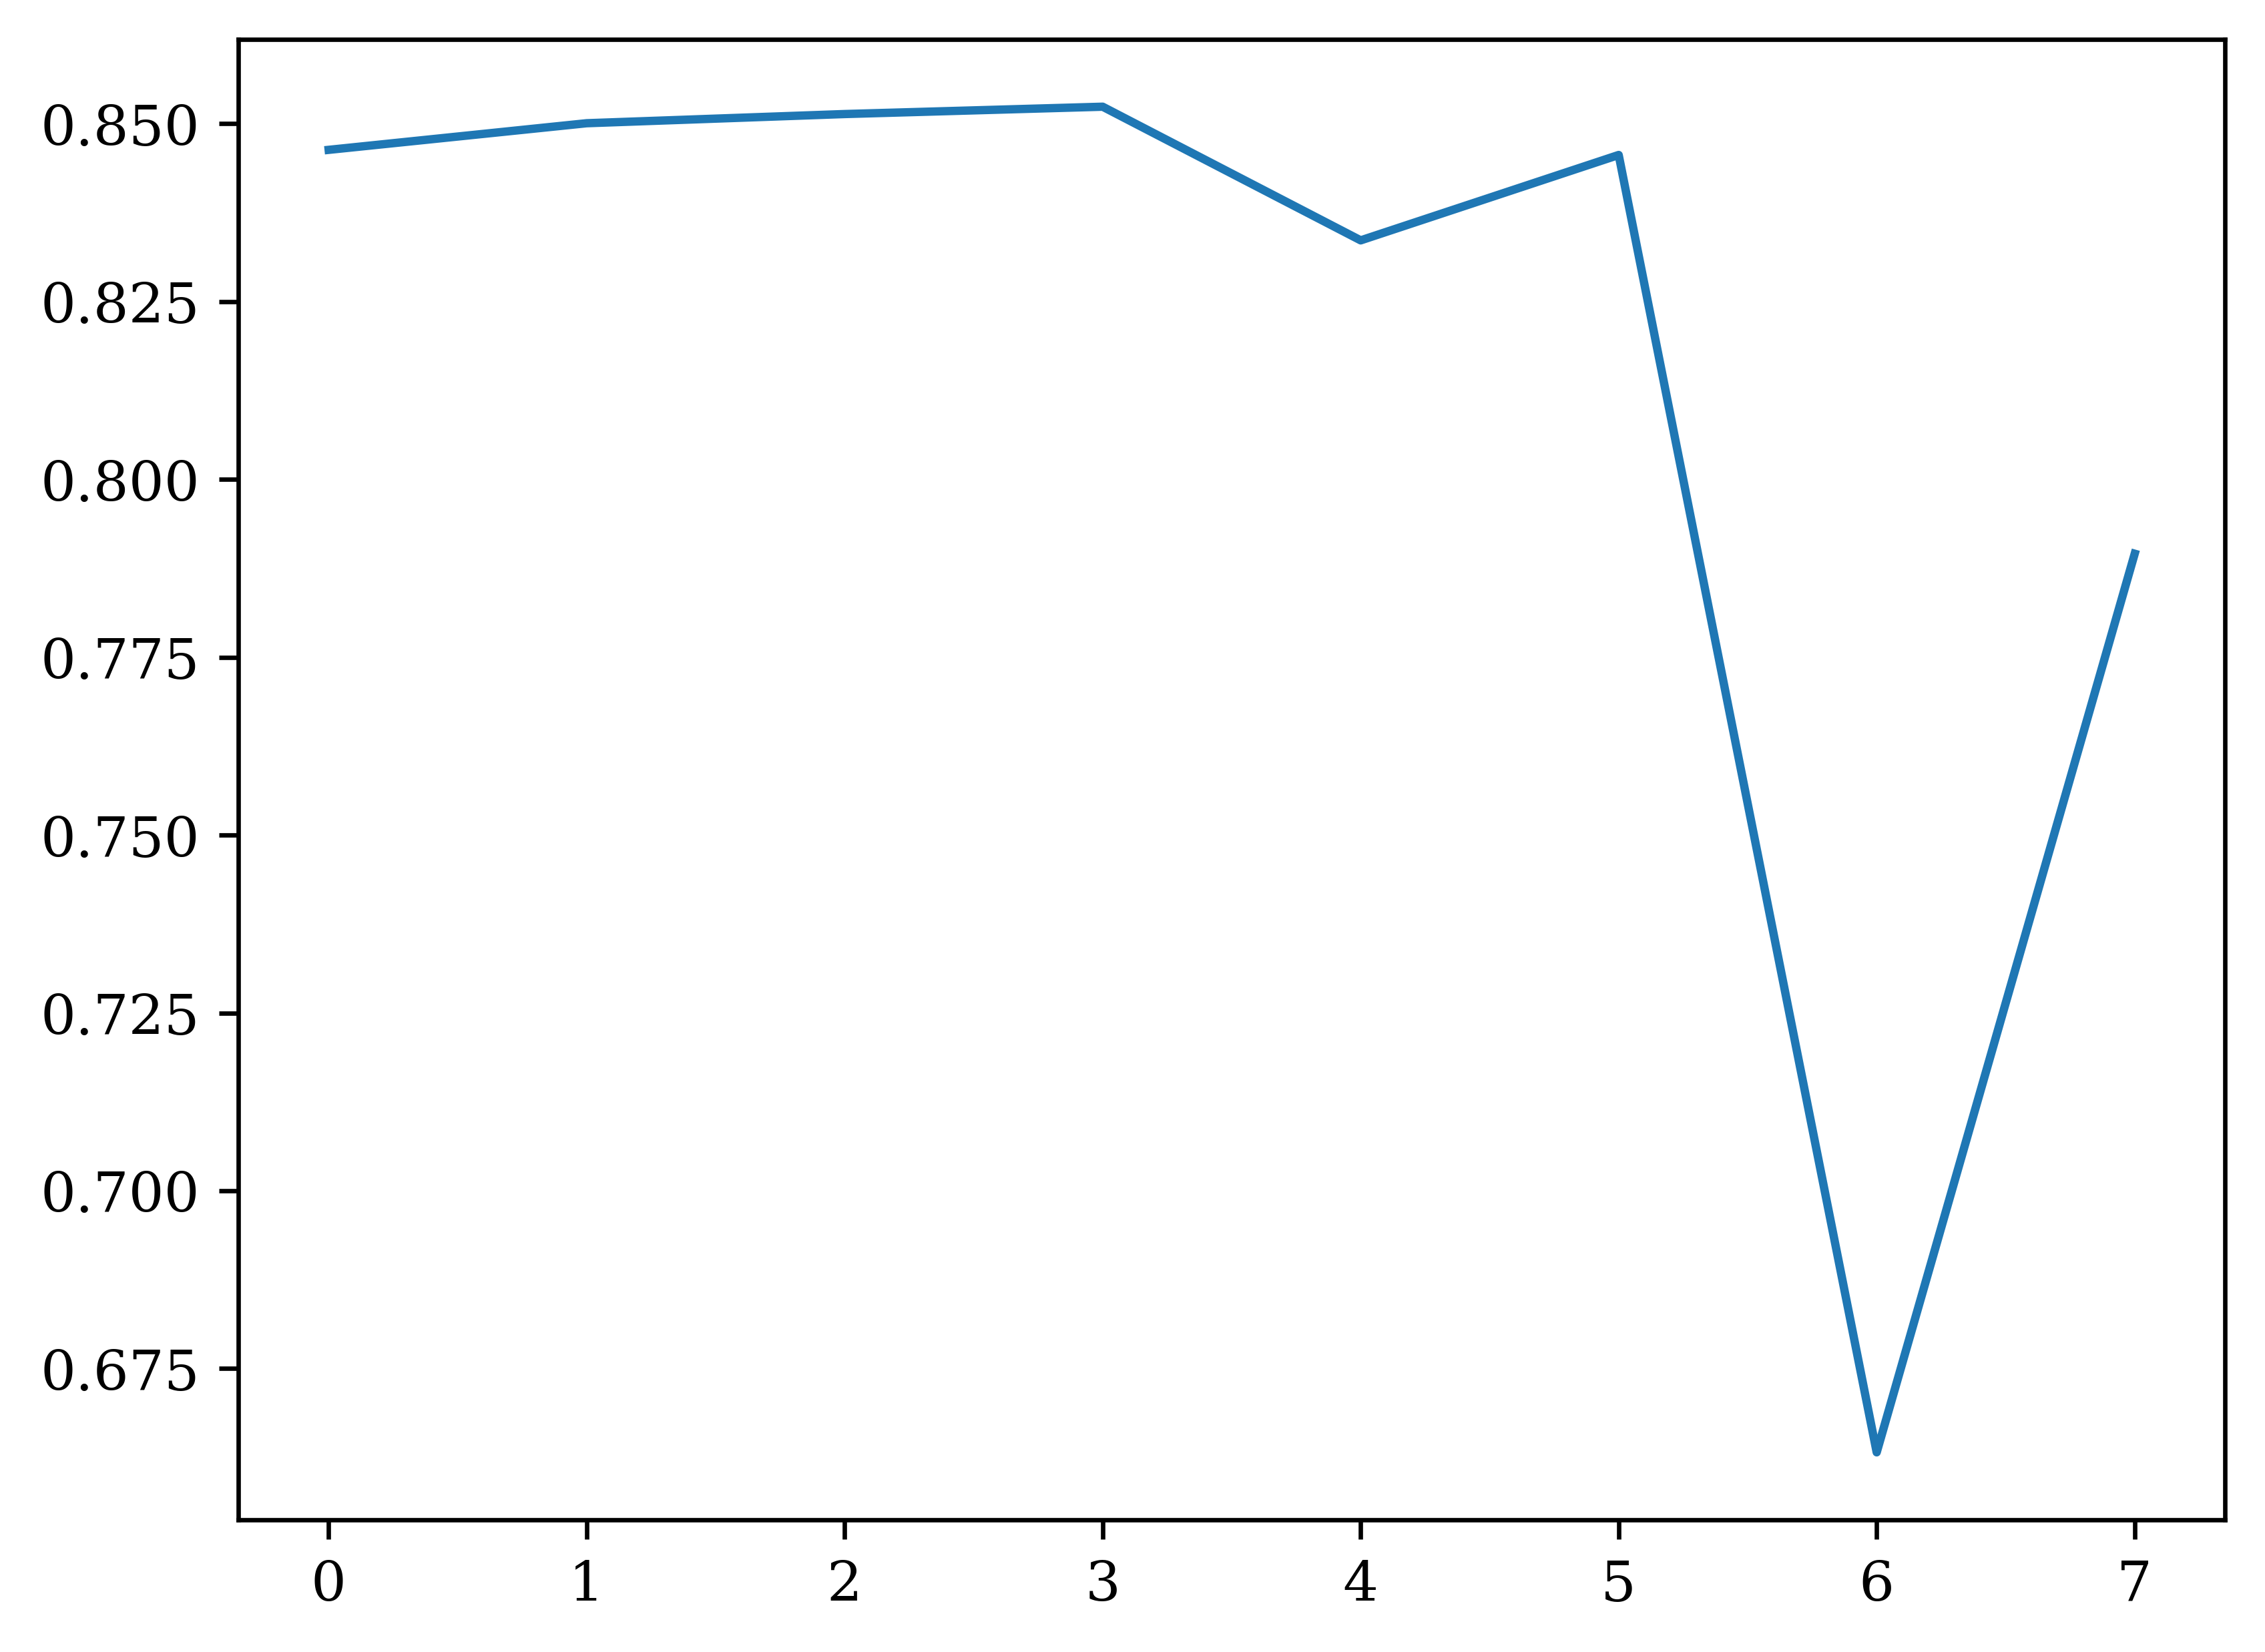

In [31]:
plt.plot((1 - corr_dists)[-1, :-1])

In [79]:
list(scalars)

['width', 'length', 'height', 'area']

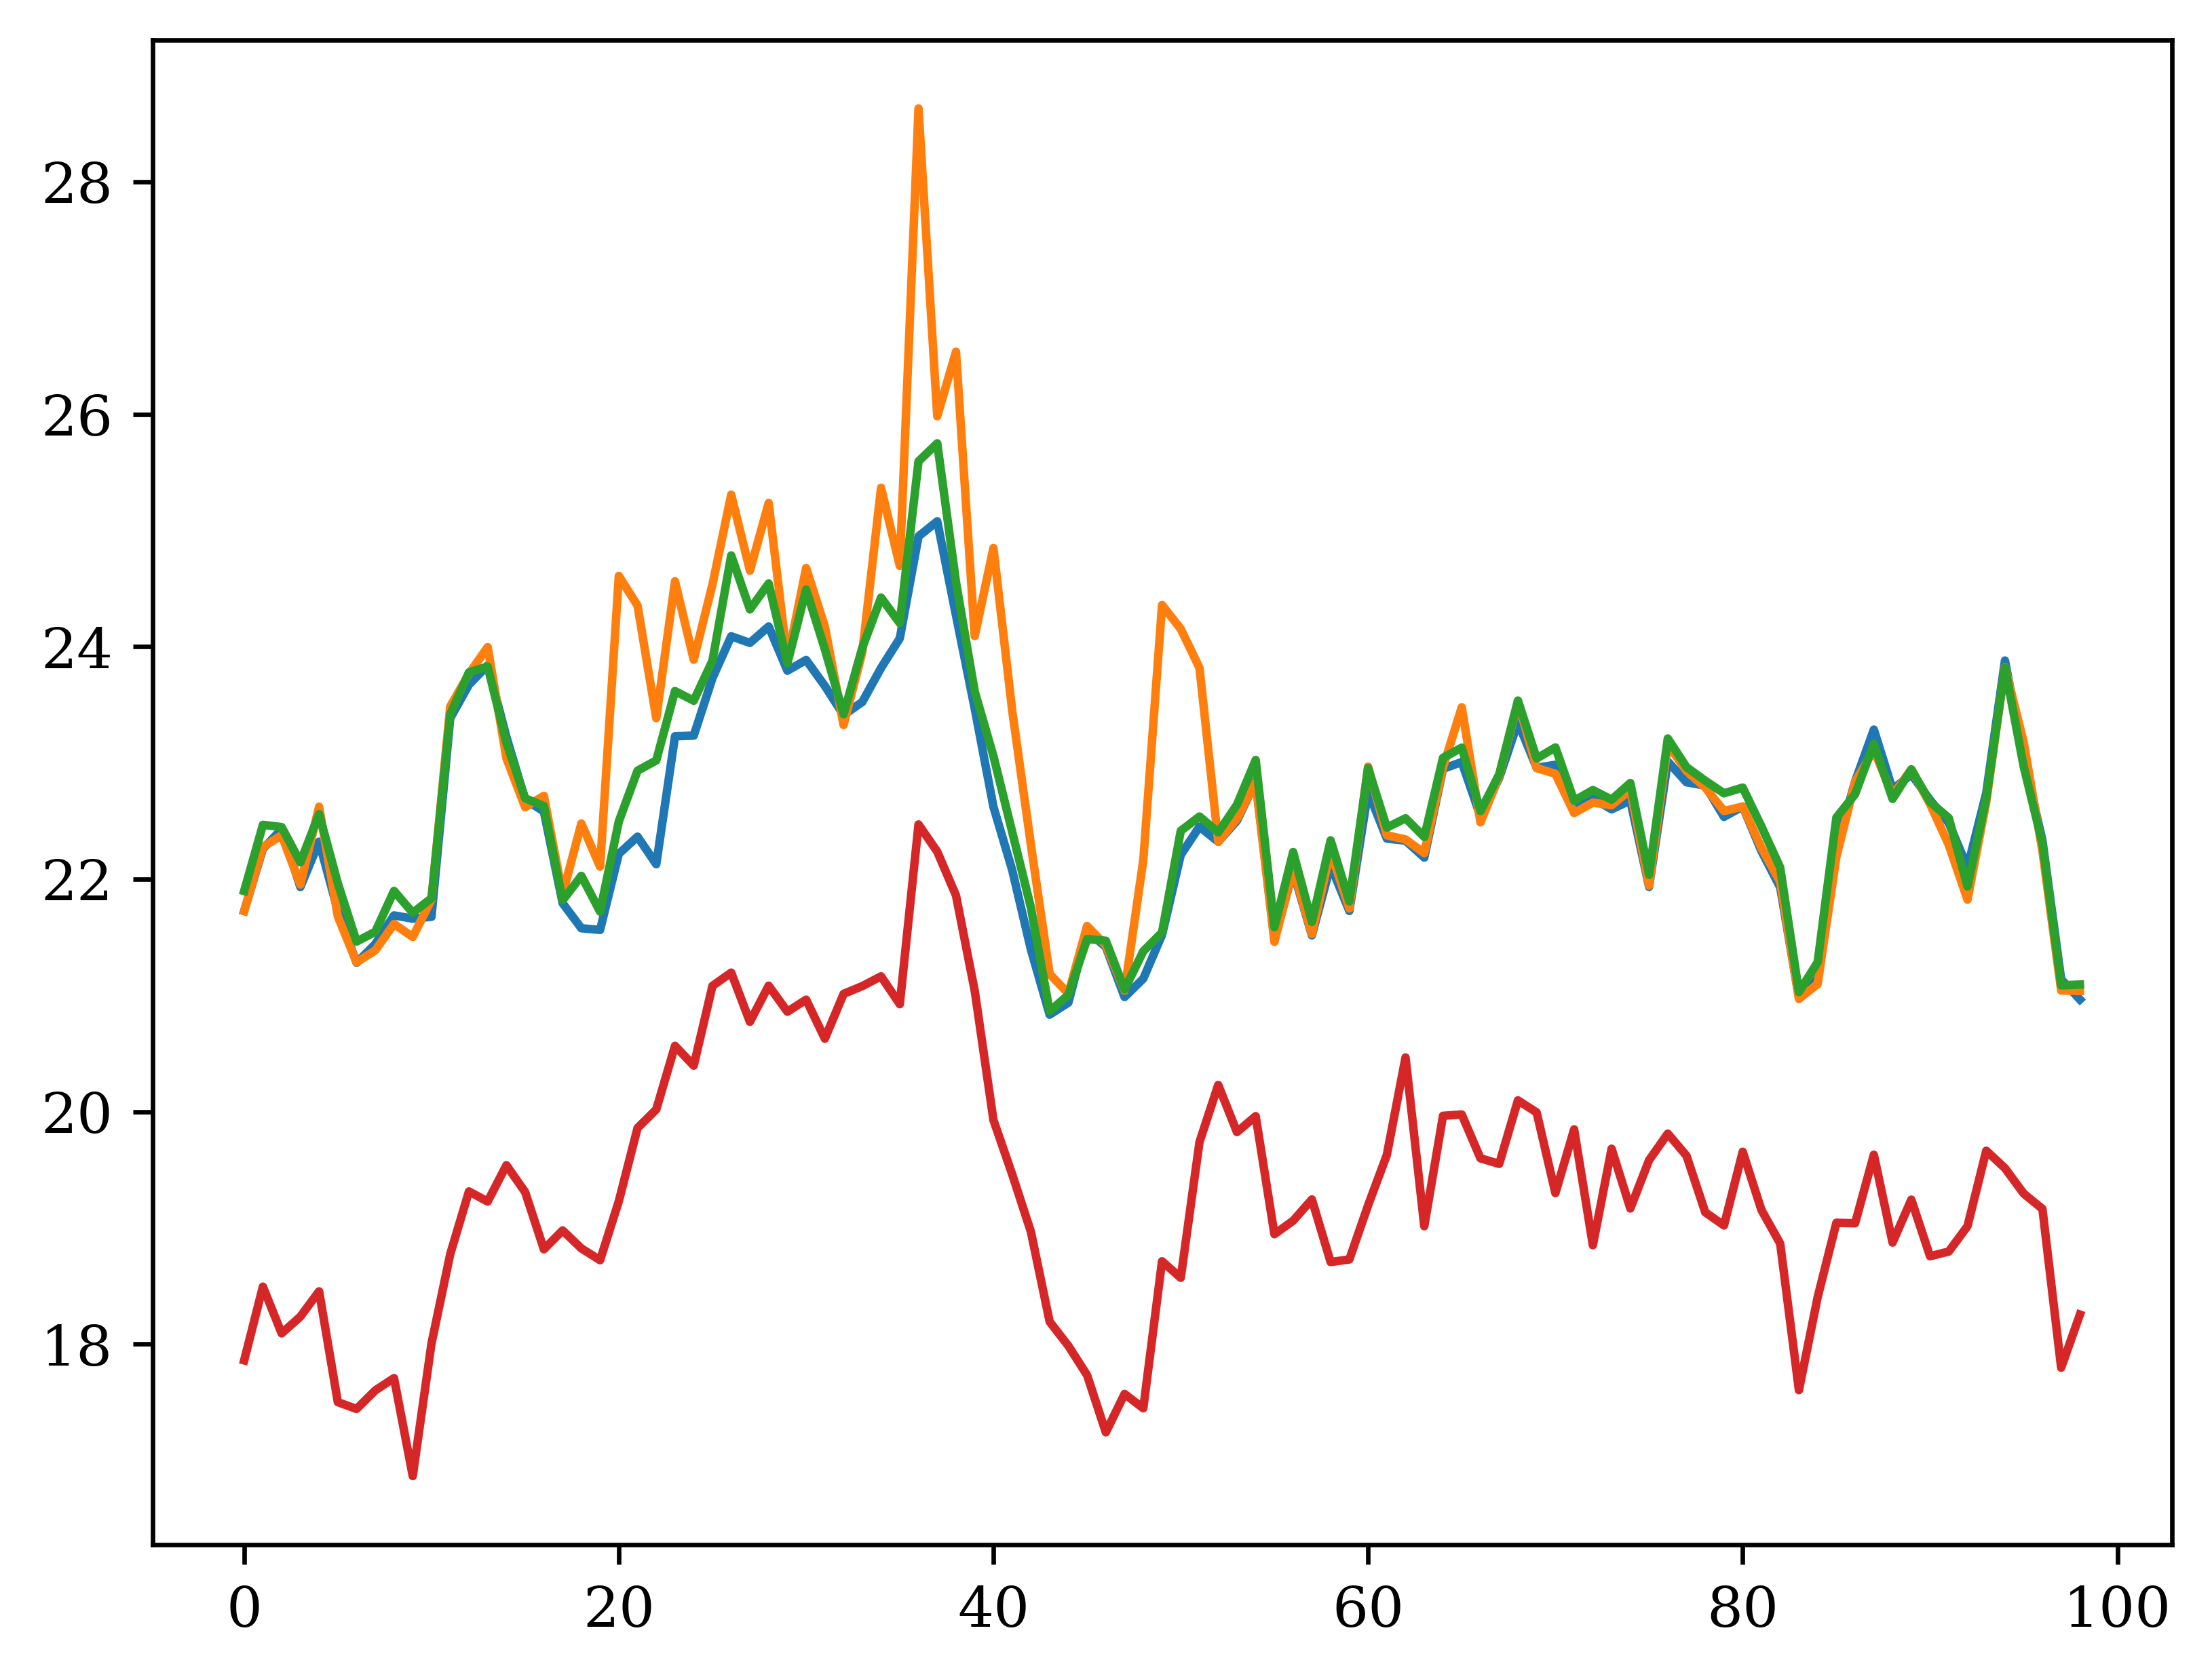

In [85]:
plt.plot(scalars['width'][1:100])
plt.plot(scalars_old['width'][1:100])
plt.plot(scalars_old2['width'][1:100])
plt.plot(recon_scalars['width'][1:100])

In [8]:
gauss_frames = gaussian_filter(frames.astype('float32'), sigma=9, axes=(1, 2))

In [9]:
gauss_recon_frames = gaussian_filter(recon_frames.astype('float32'), sigma=9, axes=(1, 2))

In [10]:
maxes = np.array([np.unravel_index(np.argmax(f), f.shape) for f in gauss_frames])
recon_maxes = np.array([np.unravel_index(np.argmax(f), f.shape) for f in gauss_recon_frames])

In [11]:
shifts = recon_maxes - maxes

In [12]:
shifts.shape

(53961, 2)

In [13]:
translated = np.array([shift(f, s) for f, s in zip(frames, shifts)])

In [14]:
mse = np.mean(np.square(translated - frames).reshape(len(frames), -1), axis=1)

In [55]:
np.where(mse > 40)[0]

array([  0, 702])

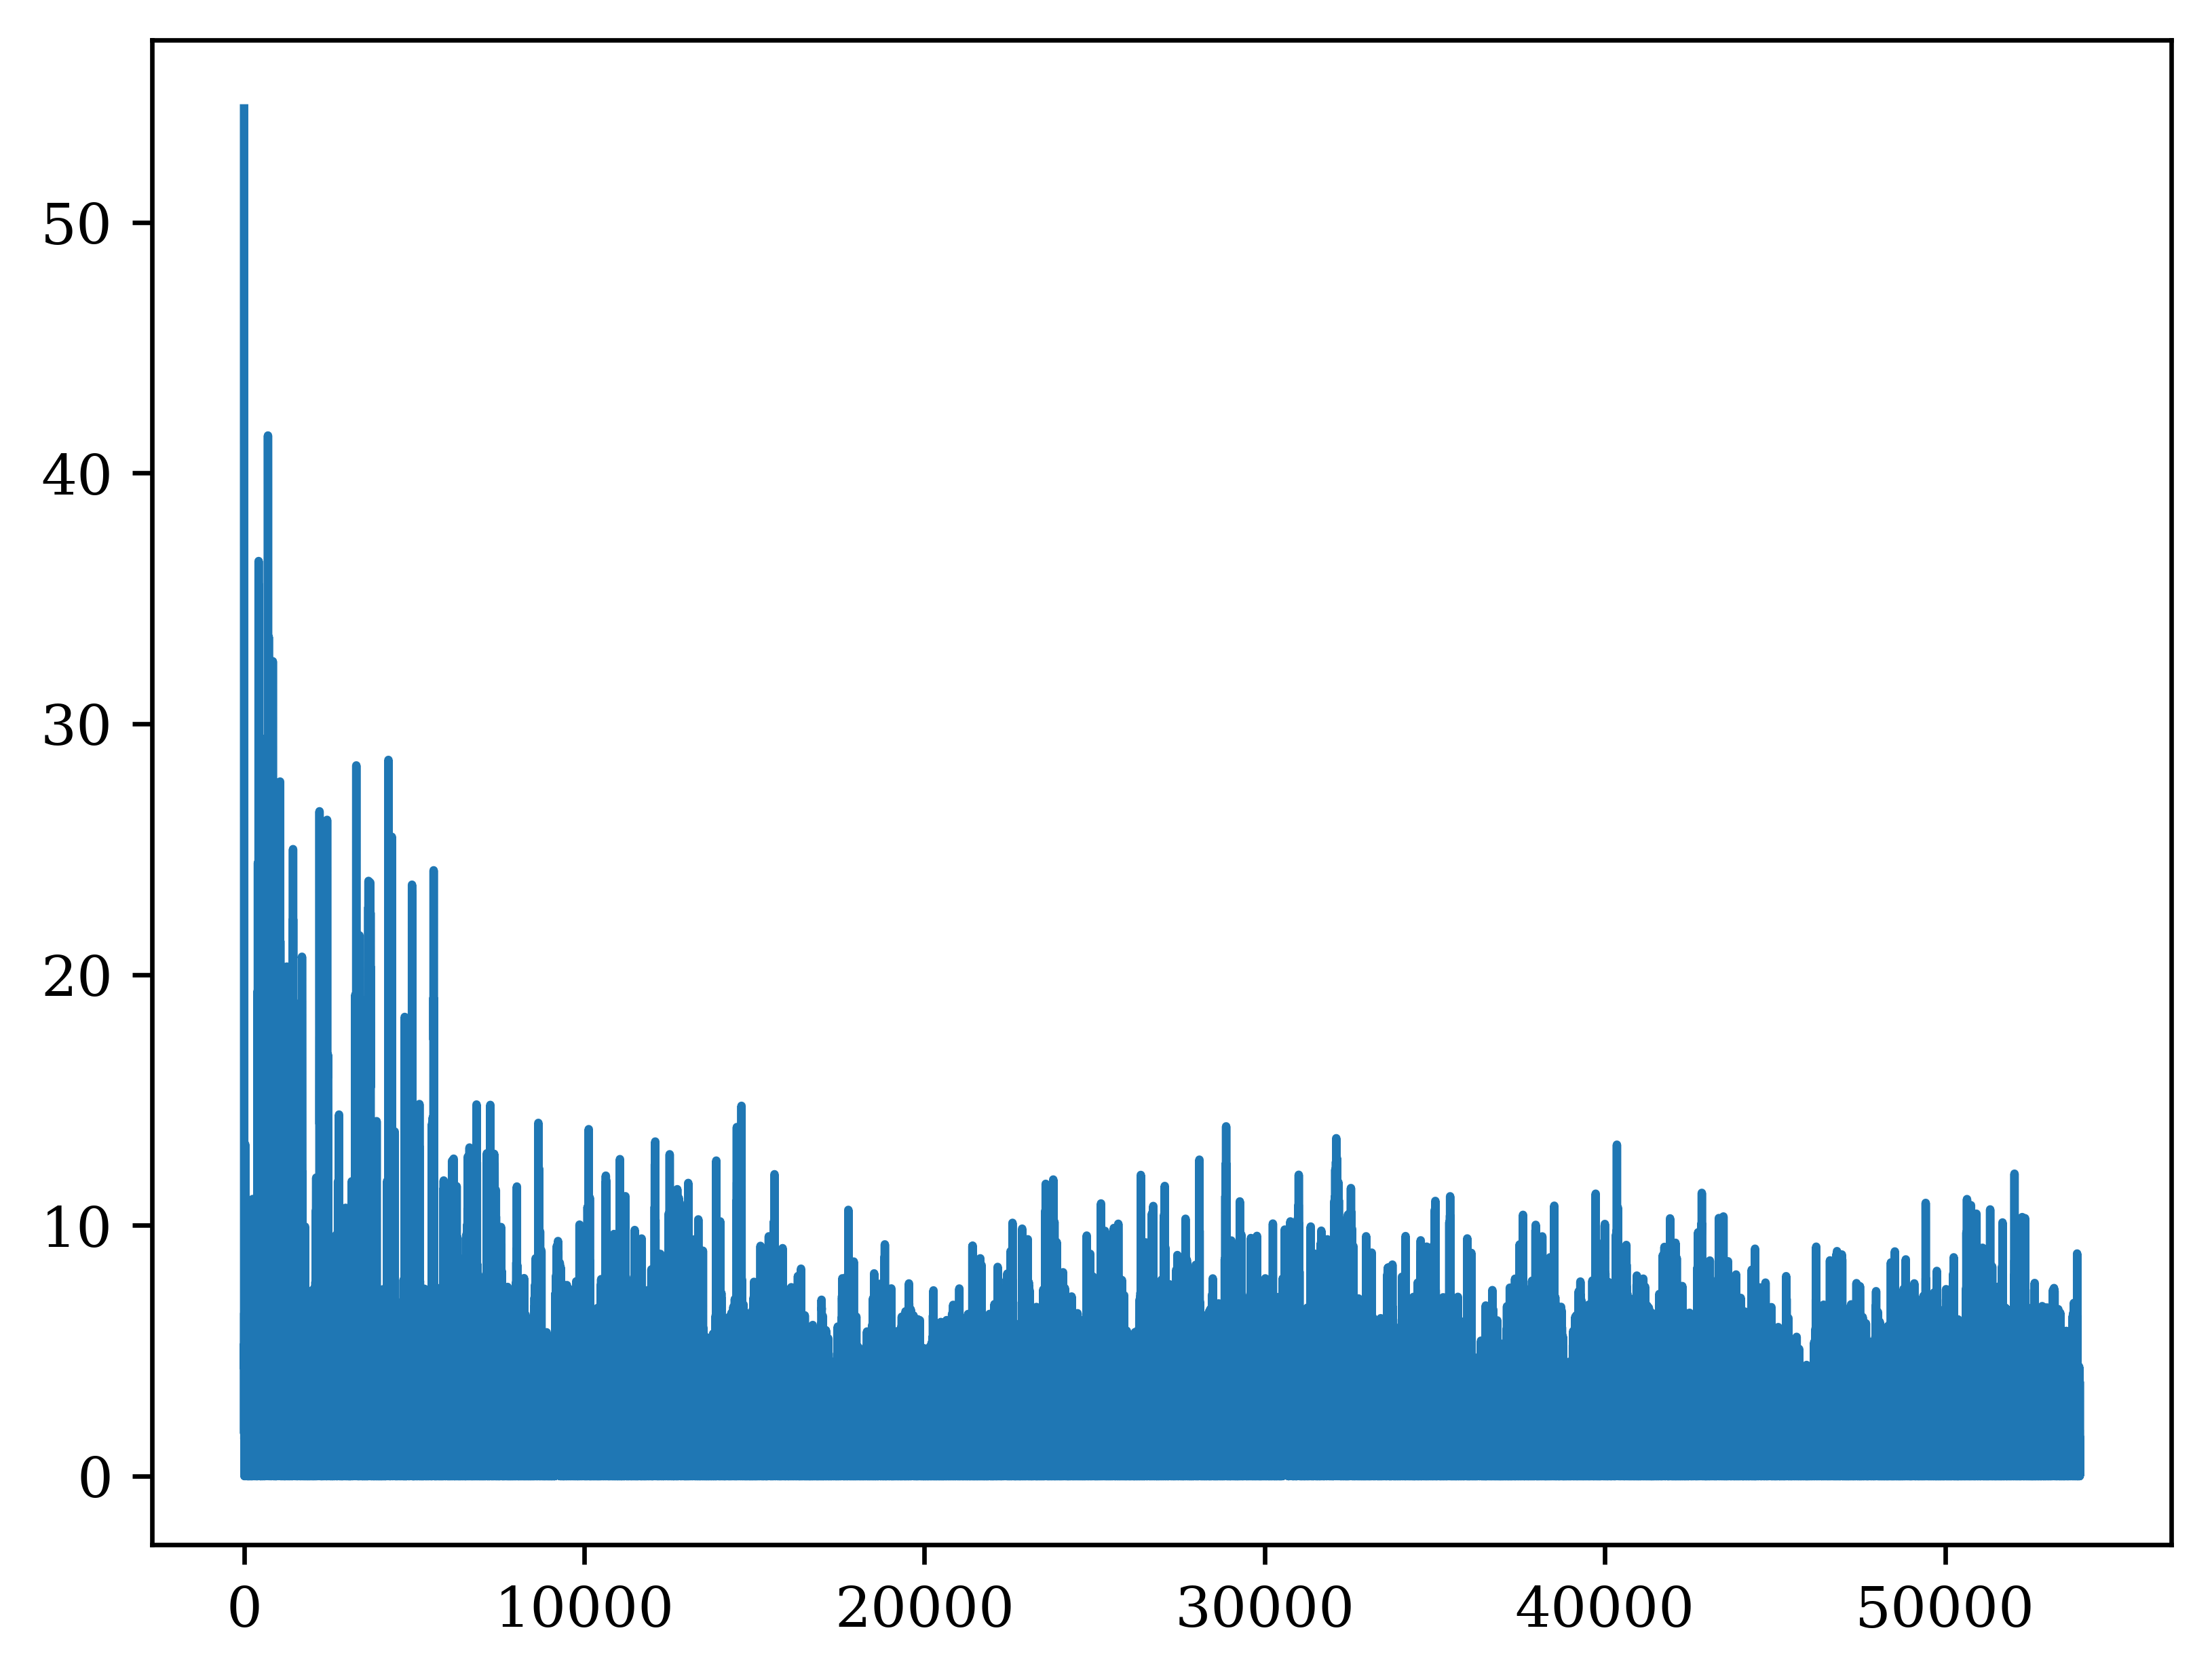

In [53]:
plt.plot(mse)

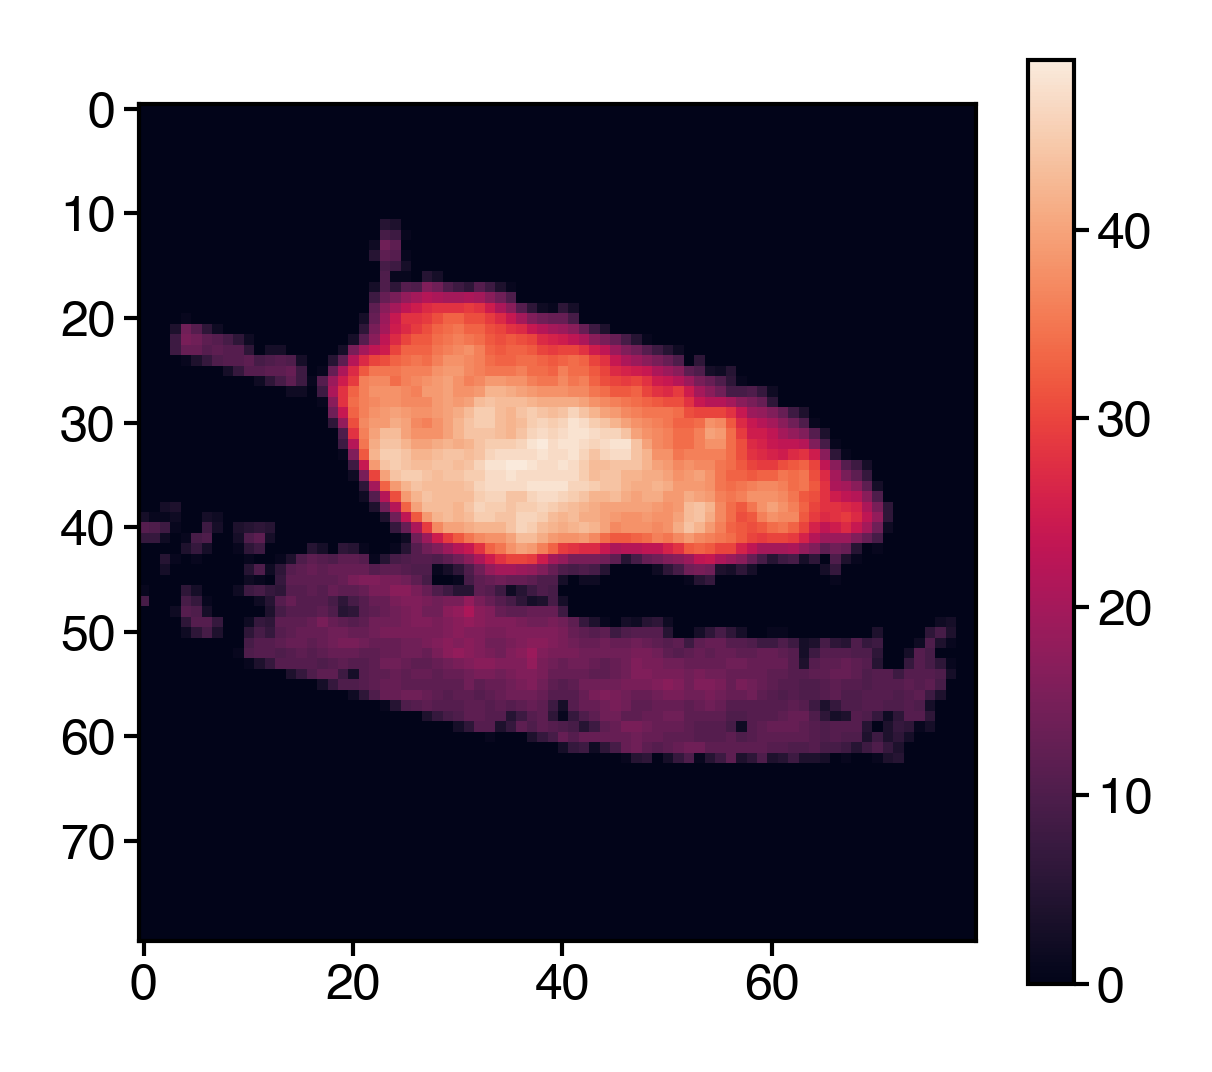

In [15]:
ind = 702
figure(2.25, 2)
plt.imshow(frames[ind])
plt.colorbar()

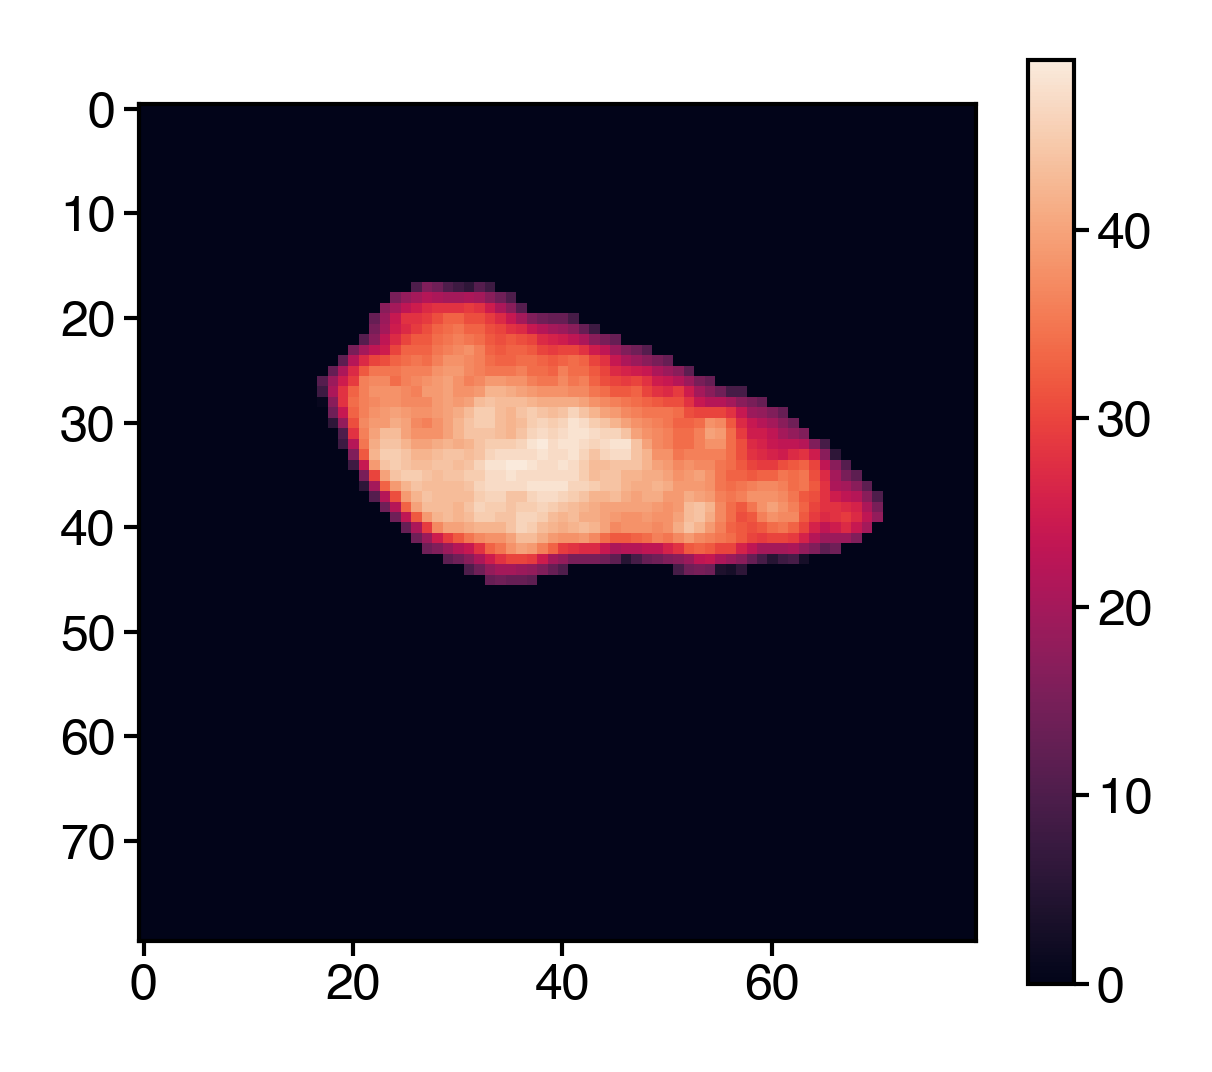

In [16]:
ind = 702
figure(2.25, 2)
plt.imshow(clean(frames[ind], height_thresh=16, tail_ksize=7))
plt.colorbar()

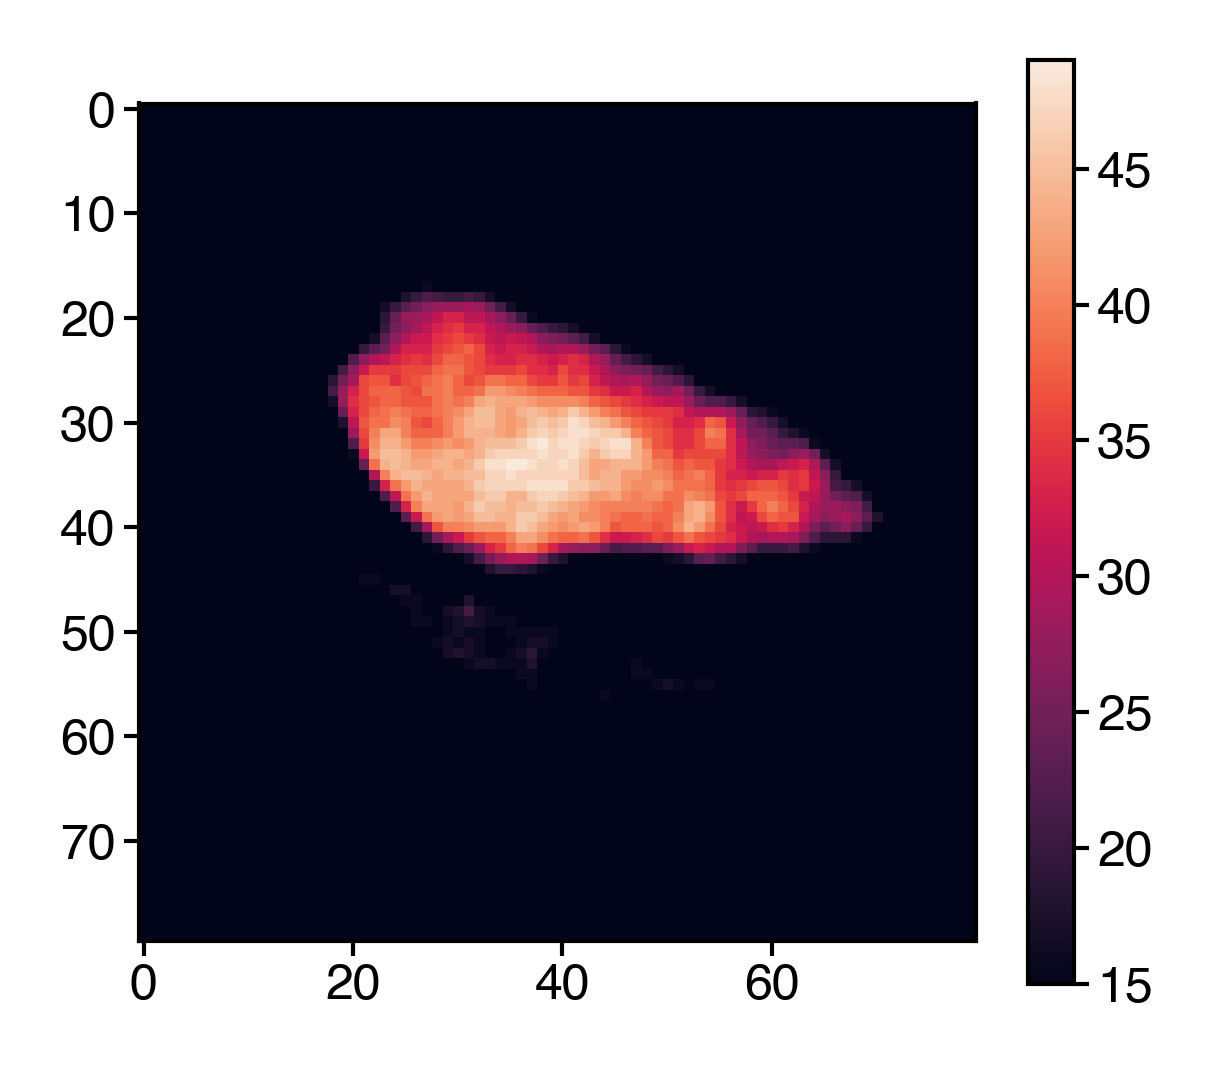

In [17]:
ind = 702
figure(2.25, 2)
plt.imshow(frames[ind], vmin=15)
plt.colorbar()

In [27]:
from toolz import partial
from scipy.ndimage import rotate
from aging.behavior.scalars import im_moment_features

In [22]:
super_clean = partial(clean, height_thresh=14, tail_ksize=7, dilation_ksize=4)

In [46]:
def alignment_function(frame, recon_frame):
    filt_frame = gaussian_filter(super_clean(frame).astype("float32"), 13)
    filt_recon_frame = gaussian_filter(recon_frame.astype("float32"), 13)

    raw_peak = np.array(np.unravel_index(np.argmax(filt_frame), filt_frame.shape))
    recon_peak = np.array(
        np.unravel_index(np.argmax(filt_recon_frame), filt_recon_frame.shape)
    )

    translated = shift(super_clean(frame), recon_peak - raw_peak)

    moments = im_moment_features(translated)
    return rotate(translated, -np.rad2deg(moments["orientation"]), reshape=False).astype(
        "uint8"
    )

In [47]:
aligned = alignment_function(frames[ind], recon_frames[ind])

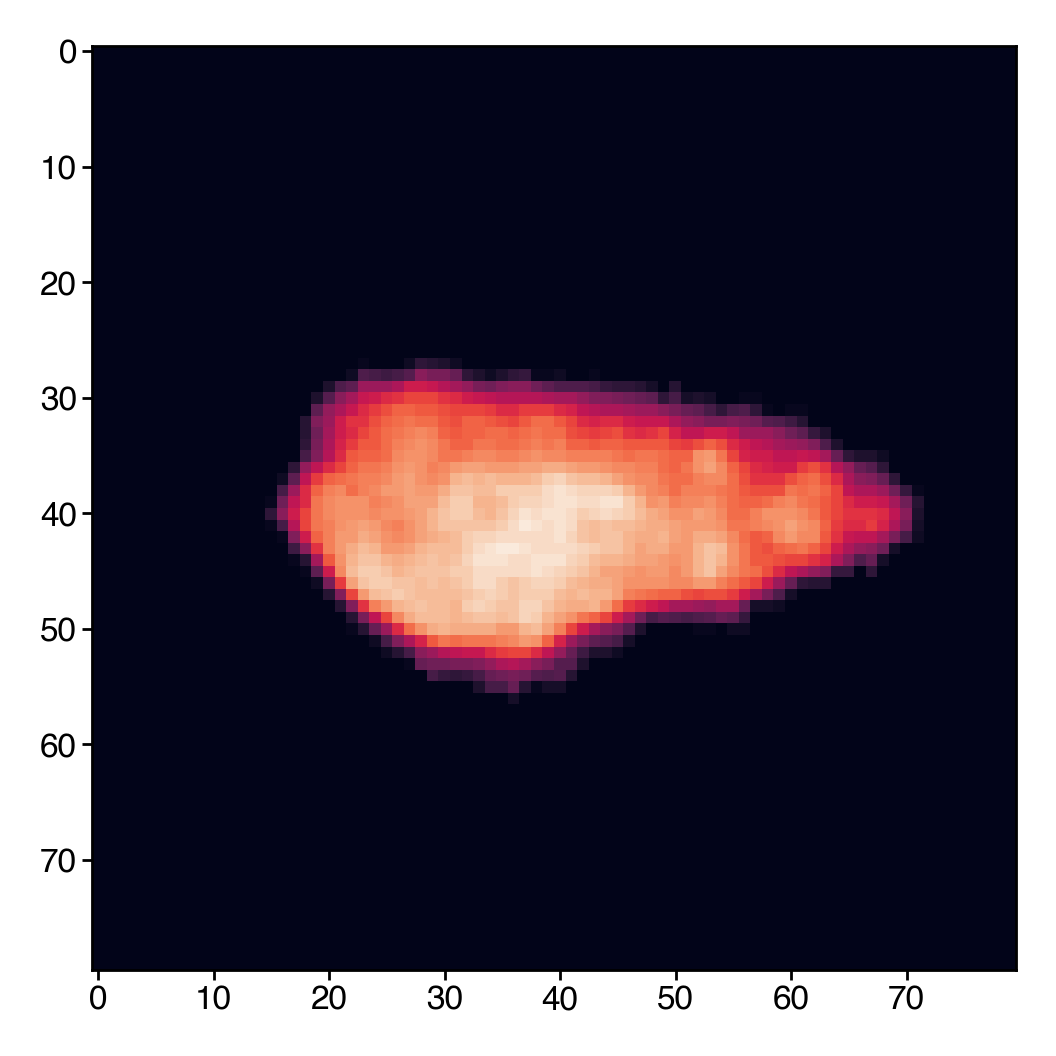

In [48]:
plt.imshow(aligned)

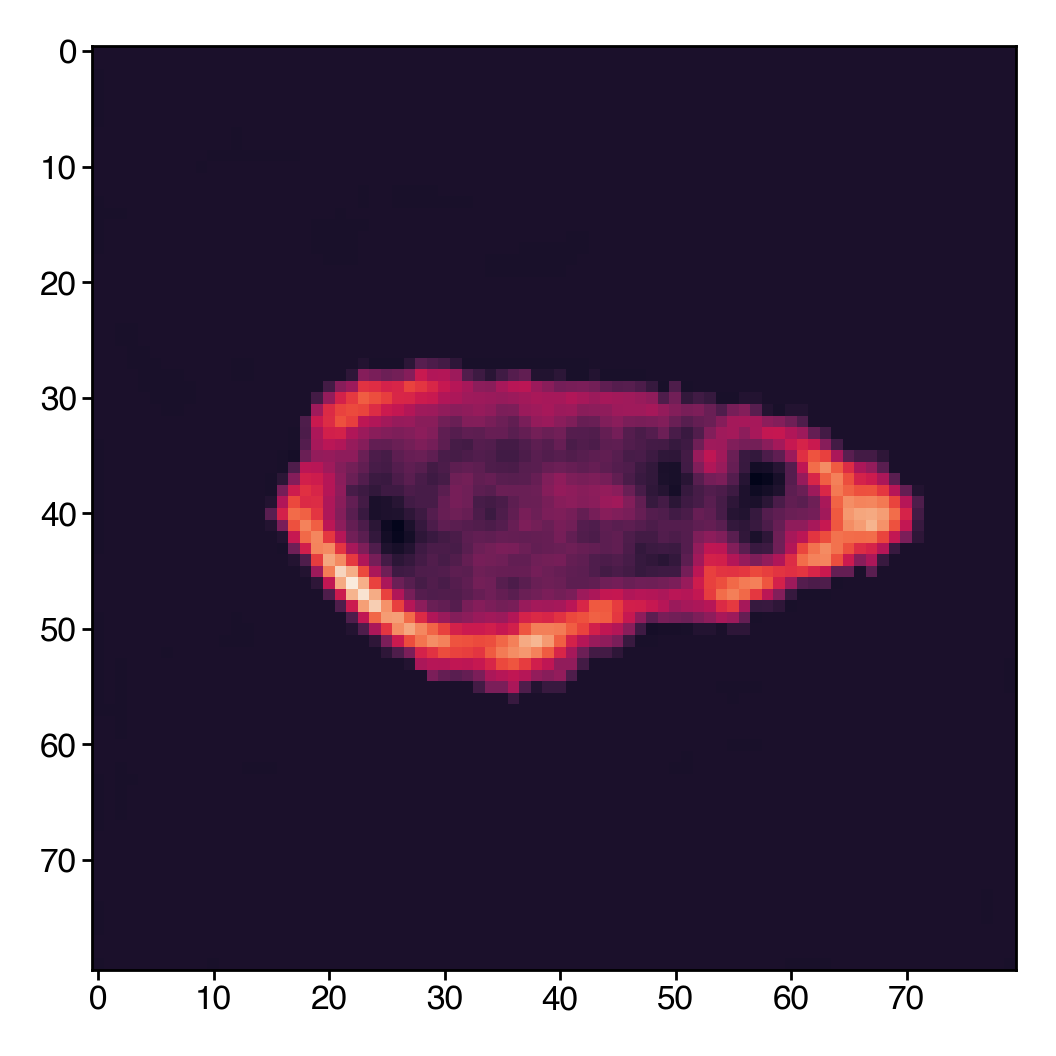

In [49]:
plt.imshow(aligned - recon_frames[ind])

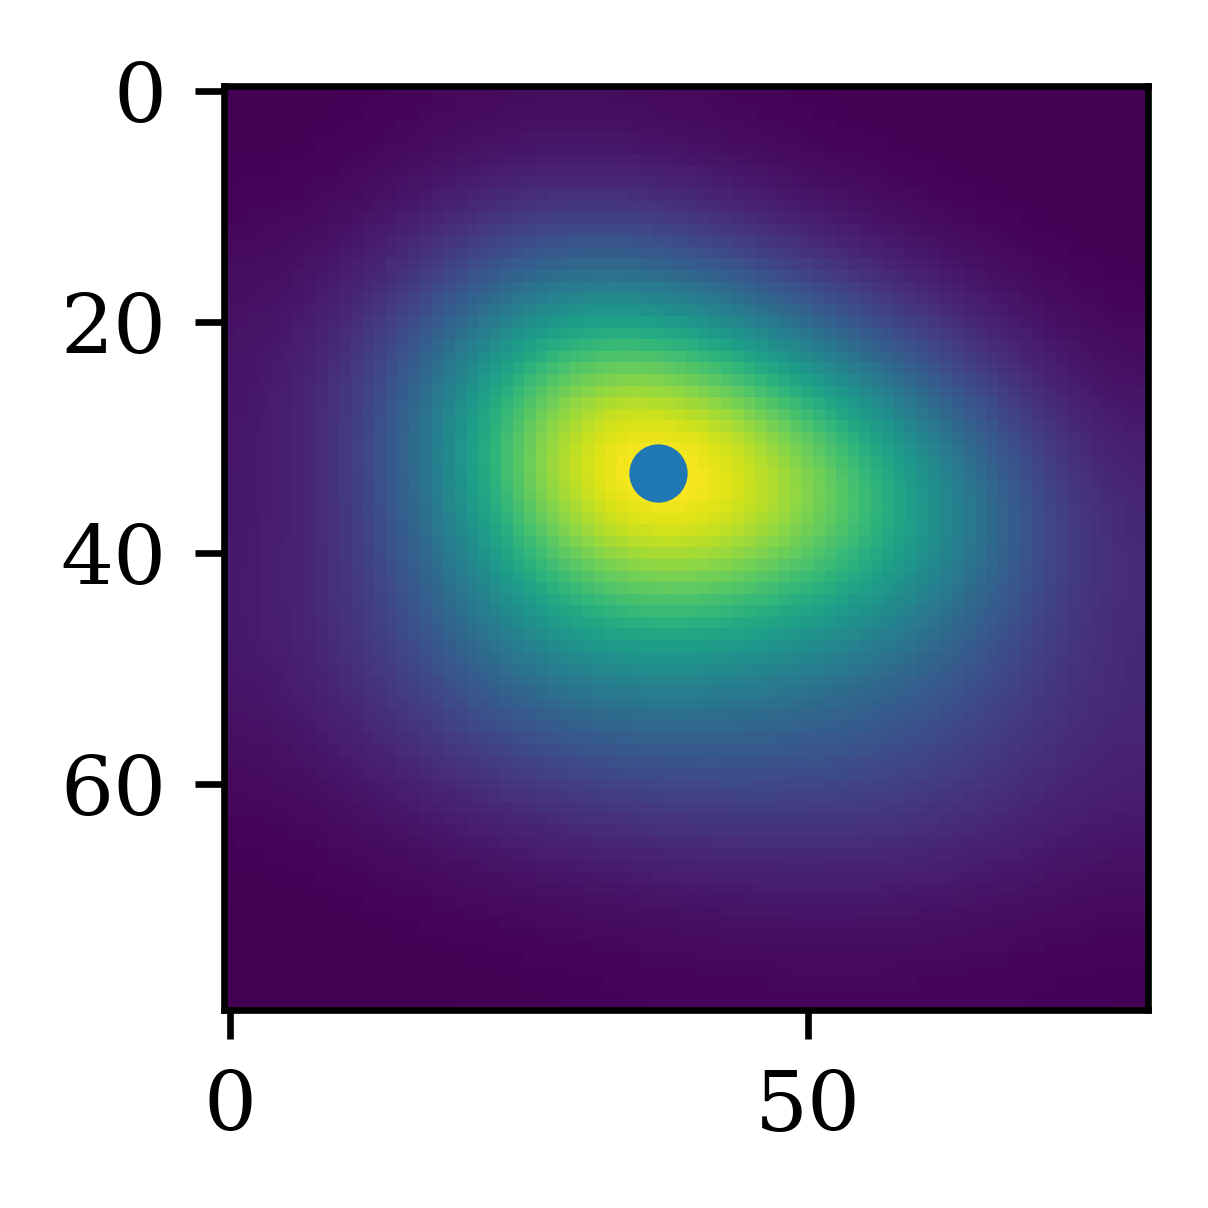

In [60]:
figure(2.25, 2)
filt_img = gaussian_filter(frames[ind].astype('float32'), 9)
raw_peak = np.unravel_index(np.argmax(filt_img), filt_img.shape)
plt.imshow(filt_img)
plt.scatter(*raw_peak[::-1])

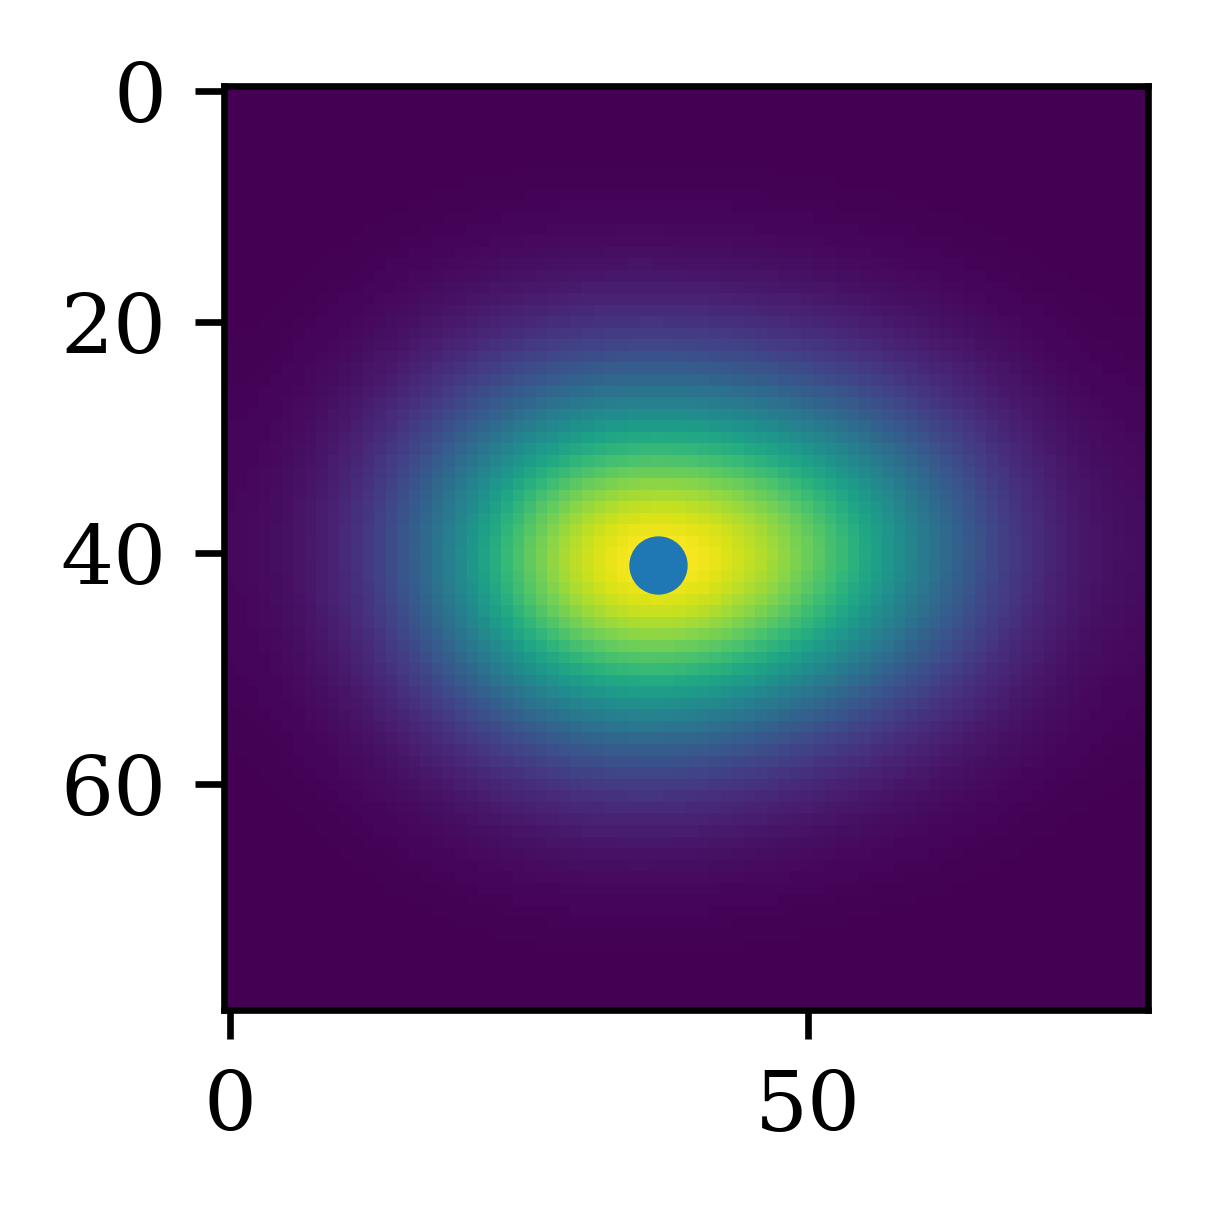

In [61]:
figure(2.25, 2)
filt_img = gaussian_filter(recon_frames[ind].astype('float32'), 9)
recon_peak = np.unravel_index(np.argmax(filt_img), filt_img.shape)
plt.imshow(filt_img)
plt.scatter(*recon_peak[::-1])

In [62]:
s = np.array(recon_peak) - np.array(raw_peak)
s

array([8, 0])

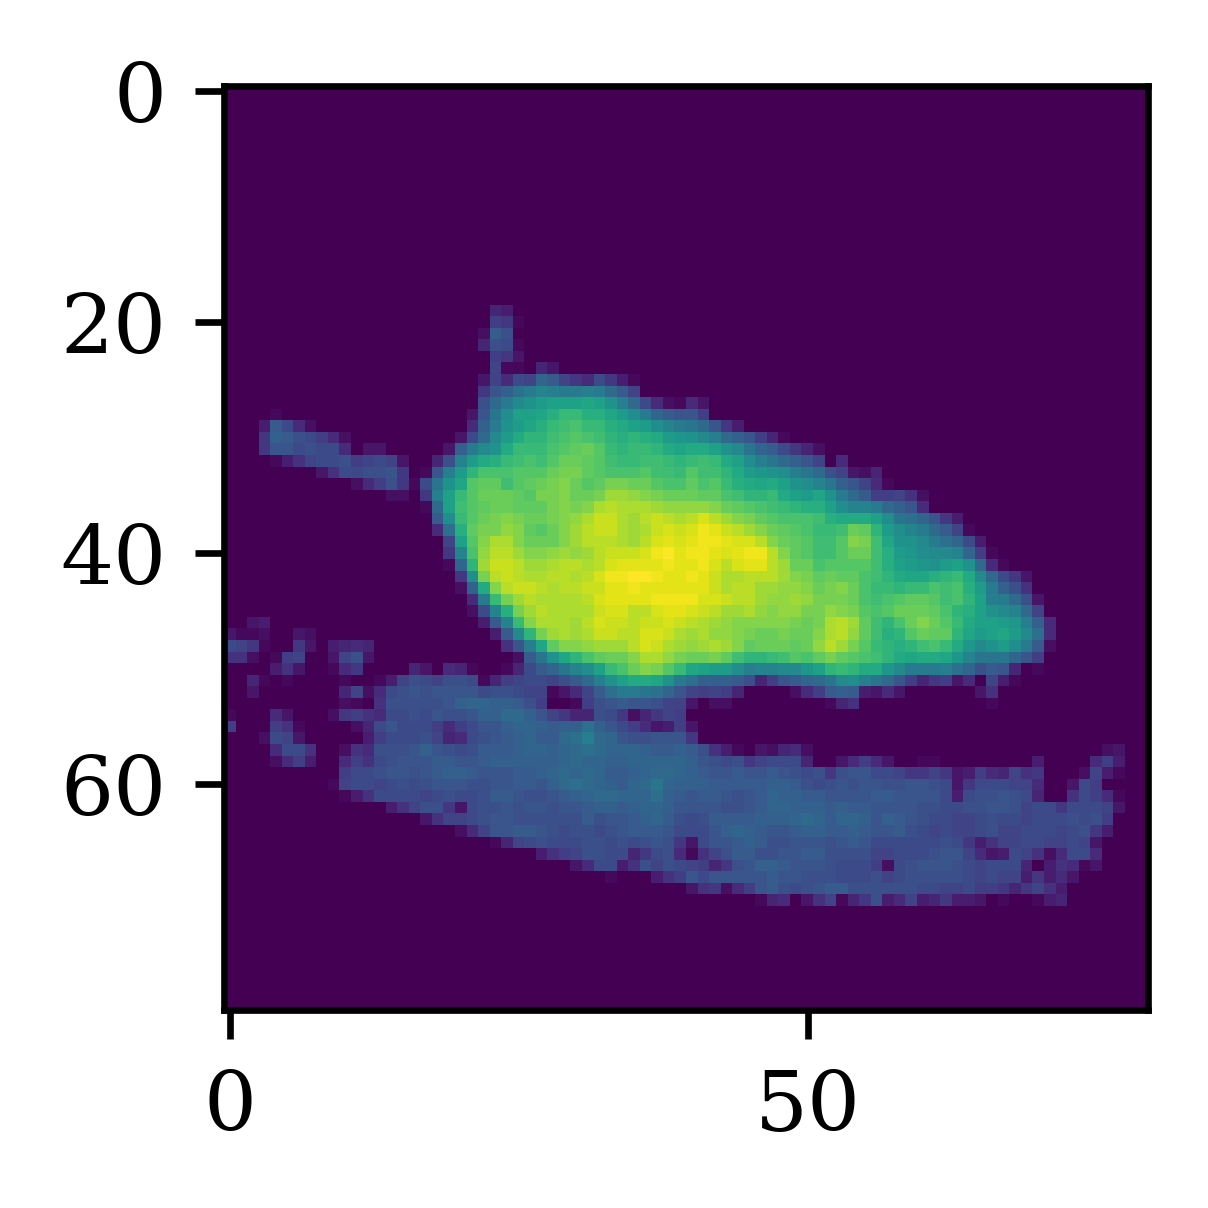

In [63]:
figure(2.25, 2)
plt.imshow(shift(frames[ind], s))

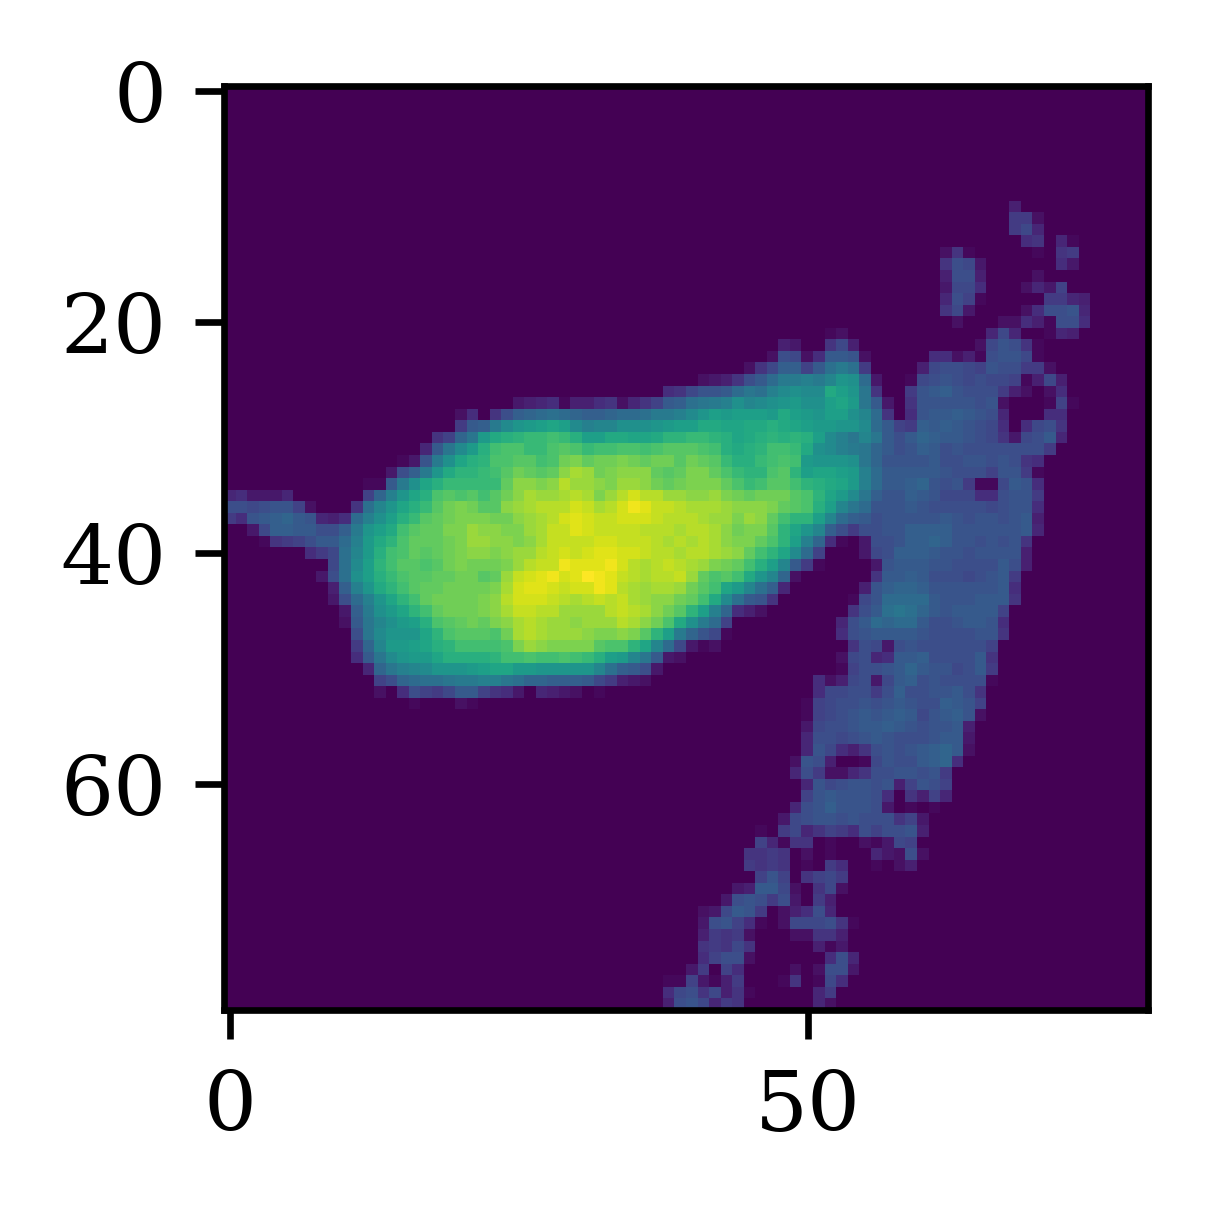

In [36]:
figure(2.25, 2)
plt.imshow(frames[ind])

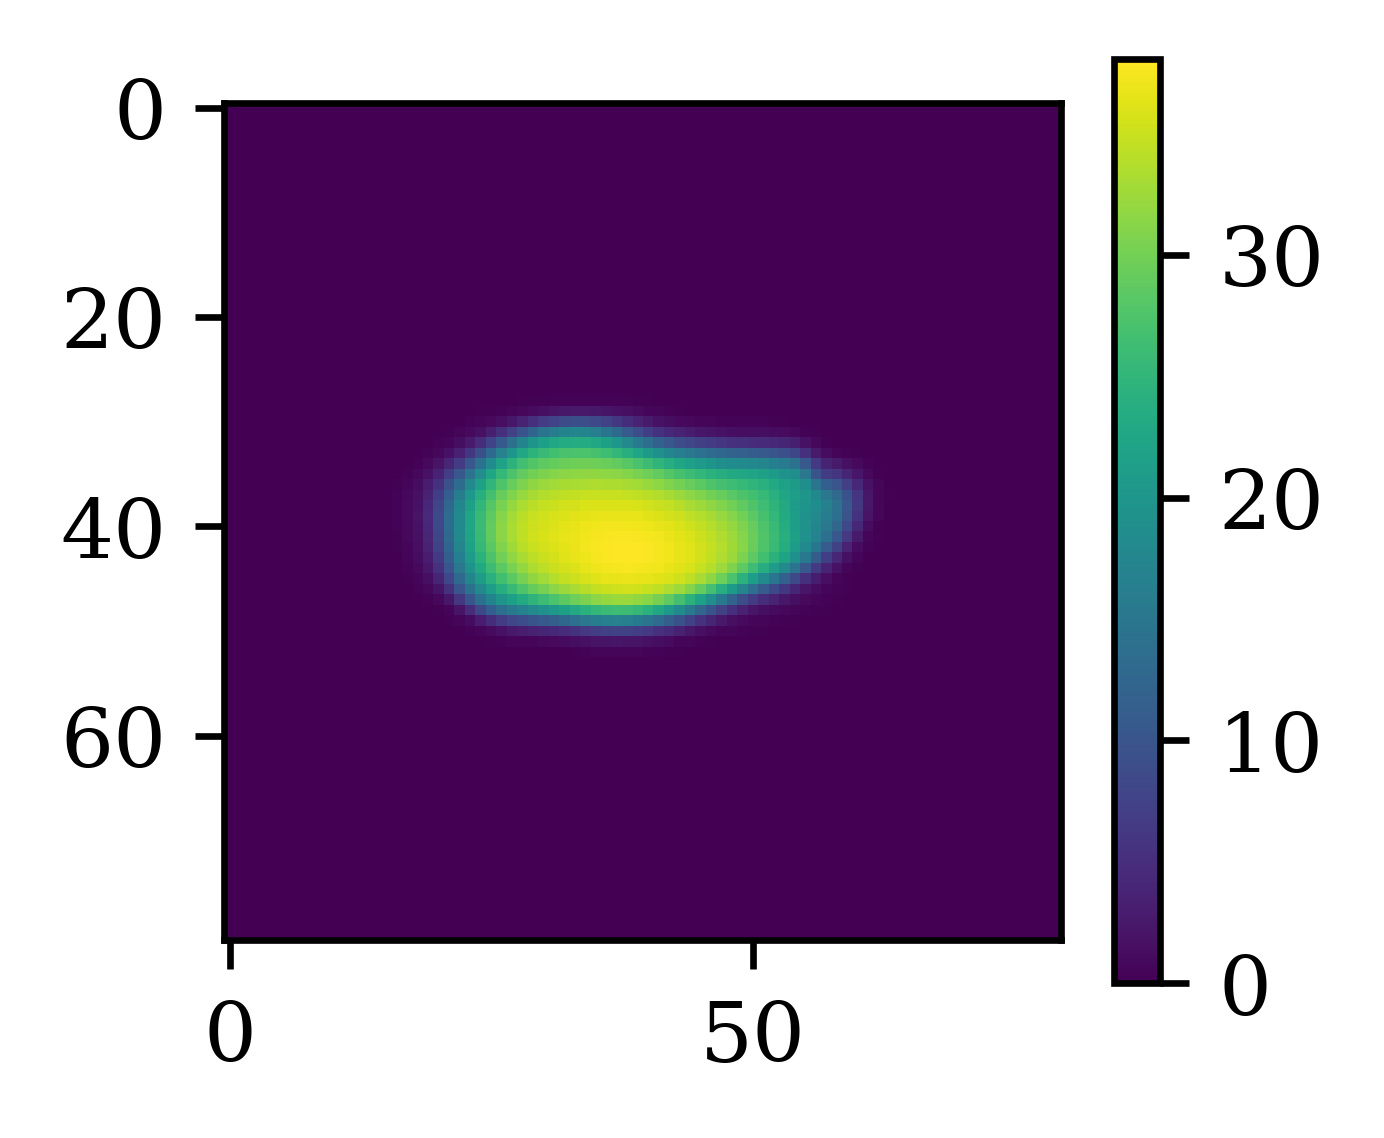

In [9]:
ind = 407
figure(2.25, 2)
plt.imshow(recon_frames[ind])
plt.colorbar()

In [33]:
list(scalars)

['width', 'length', 'height', 'area']

In [8]:
with h5py.File(files[0], 'r') as h5f:
    frames = h5f['frames'][()]
    recon_frames = h5f['win_size_norm_frames_v4'][()]
    # before_scalars = {x: h5f['scalars'][f"{x}_mm"][()] for x in ("height_ave", "width", "length")}
    session_name = h5f['metadata/acquisition/SessionName'][()].decode()
# before_scalars = keymap(lambda k: k.split('_')[0], before_scalars)

scalars = compute_scalars(
    np.array([clean(f, height_thresh=14, tail_ksize=7, dilation_ksize=4) for f in frames]),
    is_recon=False,
    height_thresh=10,
)
recon_scalars = compute_scalars(recon_frames, is_recon=False, height_thresh=10)

In [69]:
window_size = 5 * 30
inds = np.arange(0, len(frames), window_size)
sliding_corr = []
k = 'width'
for start, end in zip(inds, inds[1:]):
    sliding_corr.append(pearsonr(np.nan_to_num(scalars[k][start:end]), np.nan_to_num(recon_scalars[k][start:end]))[0])

In [70]:
out = inds[np.argsort(sliding_corr)]
out

array([53550, 52350, 50700, 20700, 30600, 46950, 38850, 34800, 16350,
       35850, 33600, 45750, 48150, 48300, 23700, 37350, 28650, 36300,
       52200, 44100, 47100, 20550, 45600, 49800,  1950, 34050, 19050,
       13650, 17250, 15750, 10200, 44250, 32400, 38250, 11850, 39600,
       12150, 53100,  8550, 17400,   450, 22800, 43200, 35100, 27300,
       22950, 43800, 27600, 52800, 21300, 26550, 49950, 19500, 51900,
       31500, 30150, 38400, 37800, 20100, 24000, 40050, 34950,  9150,
       49200, 30450, 18900,  3150, 23100, 27750, 15000, 41850, 26700,
       48000, 21150, 42300, 25050, 52500, 39150, 44400, 38100, 26400,
        6900, 39300, 33750,  3900,  1200, 36900, 39900, 36150,  4200,
       32700, 42150, 27000, 24300, 26850, 29250, 32100,  7050,  7650,
       35700, 21450, 43350, 24900, 15900, 36450, 22350, 50100, 20400,
       32850, 15600, 51150, 10950, 33900, 31950, 42600, 41400, 36750,
        1800, 19350, 18450, 49350, 21900, 34350, 29850, 28800,  9600,
       53700,   600,

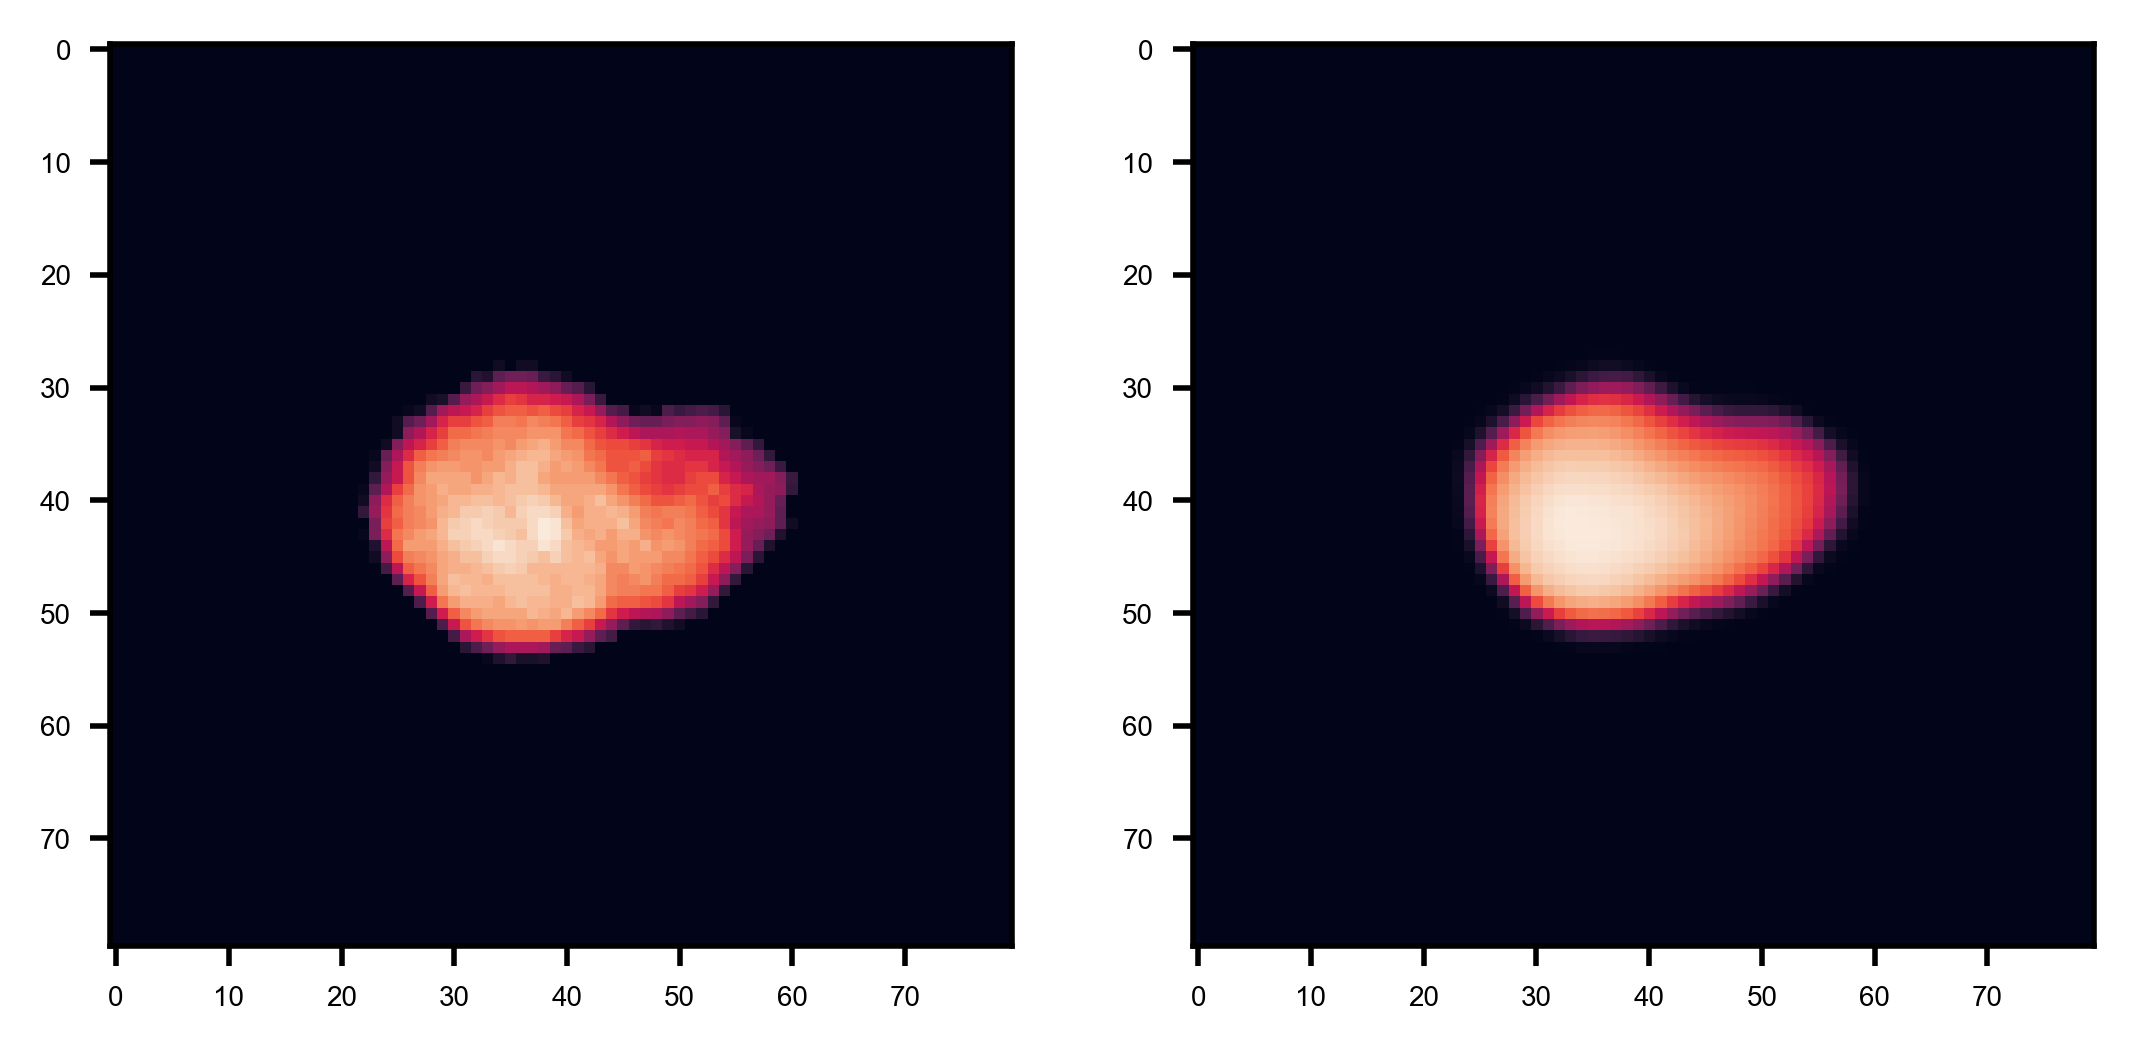

In [72]:
fig, ax = plt.subplots(1, 2)
idx = 300
example = out[1]

ax[0].imshow(frames[example + idx])
ax[1].imshow(recon_frames[example + idx])

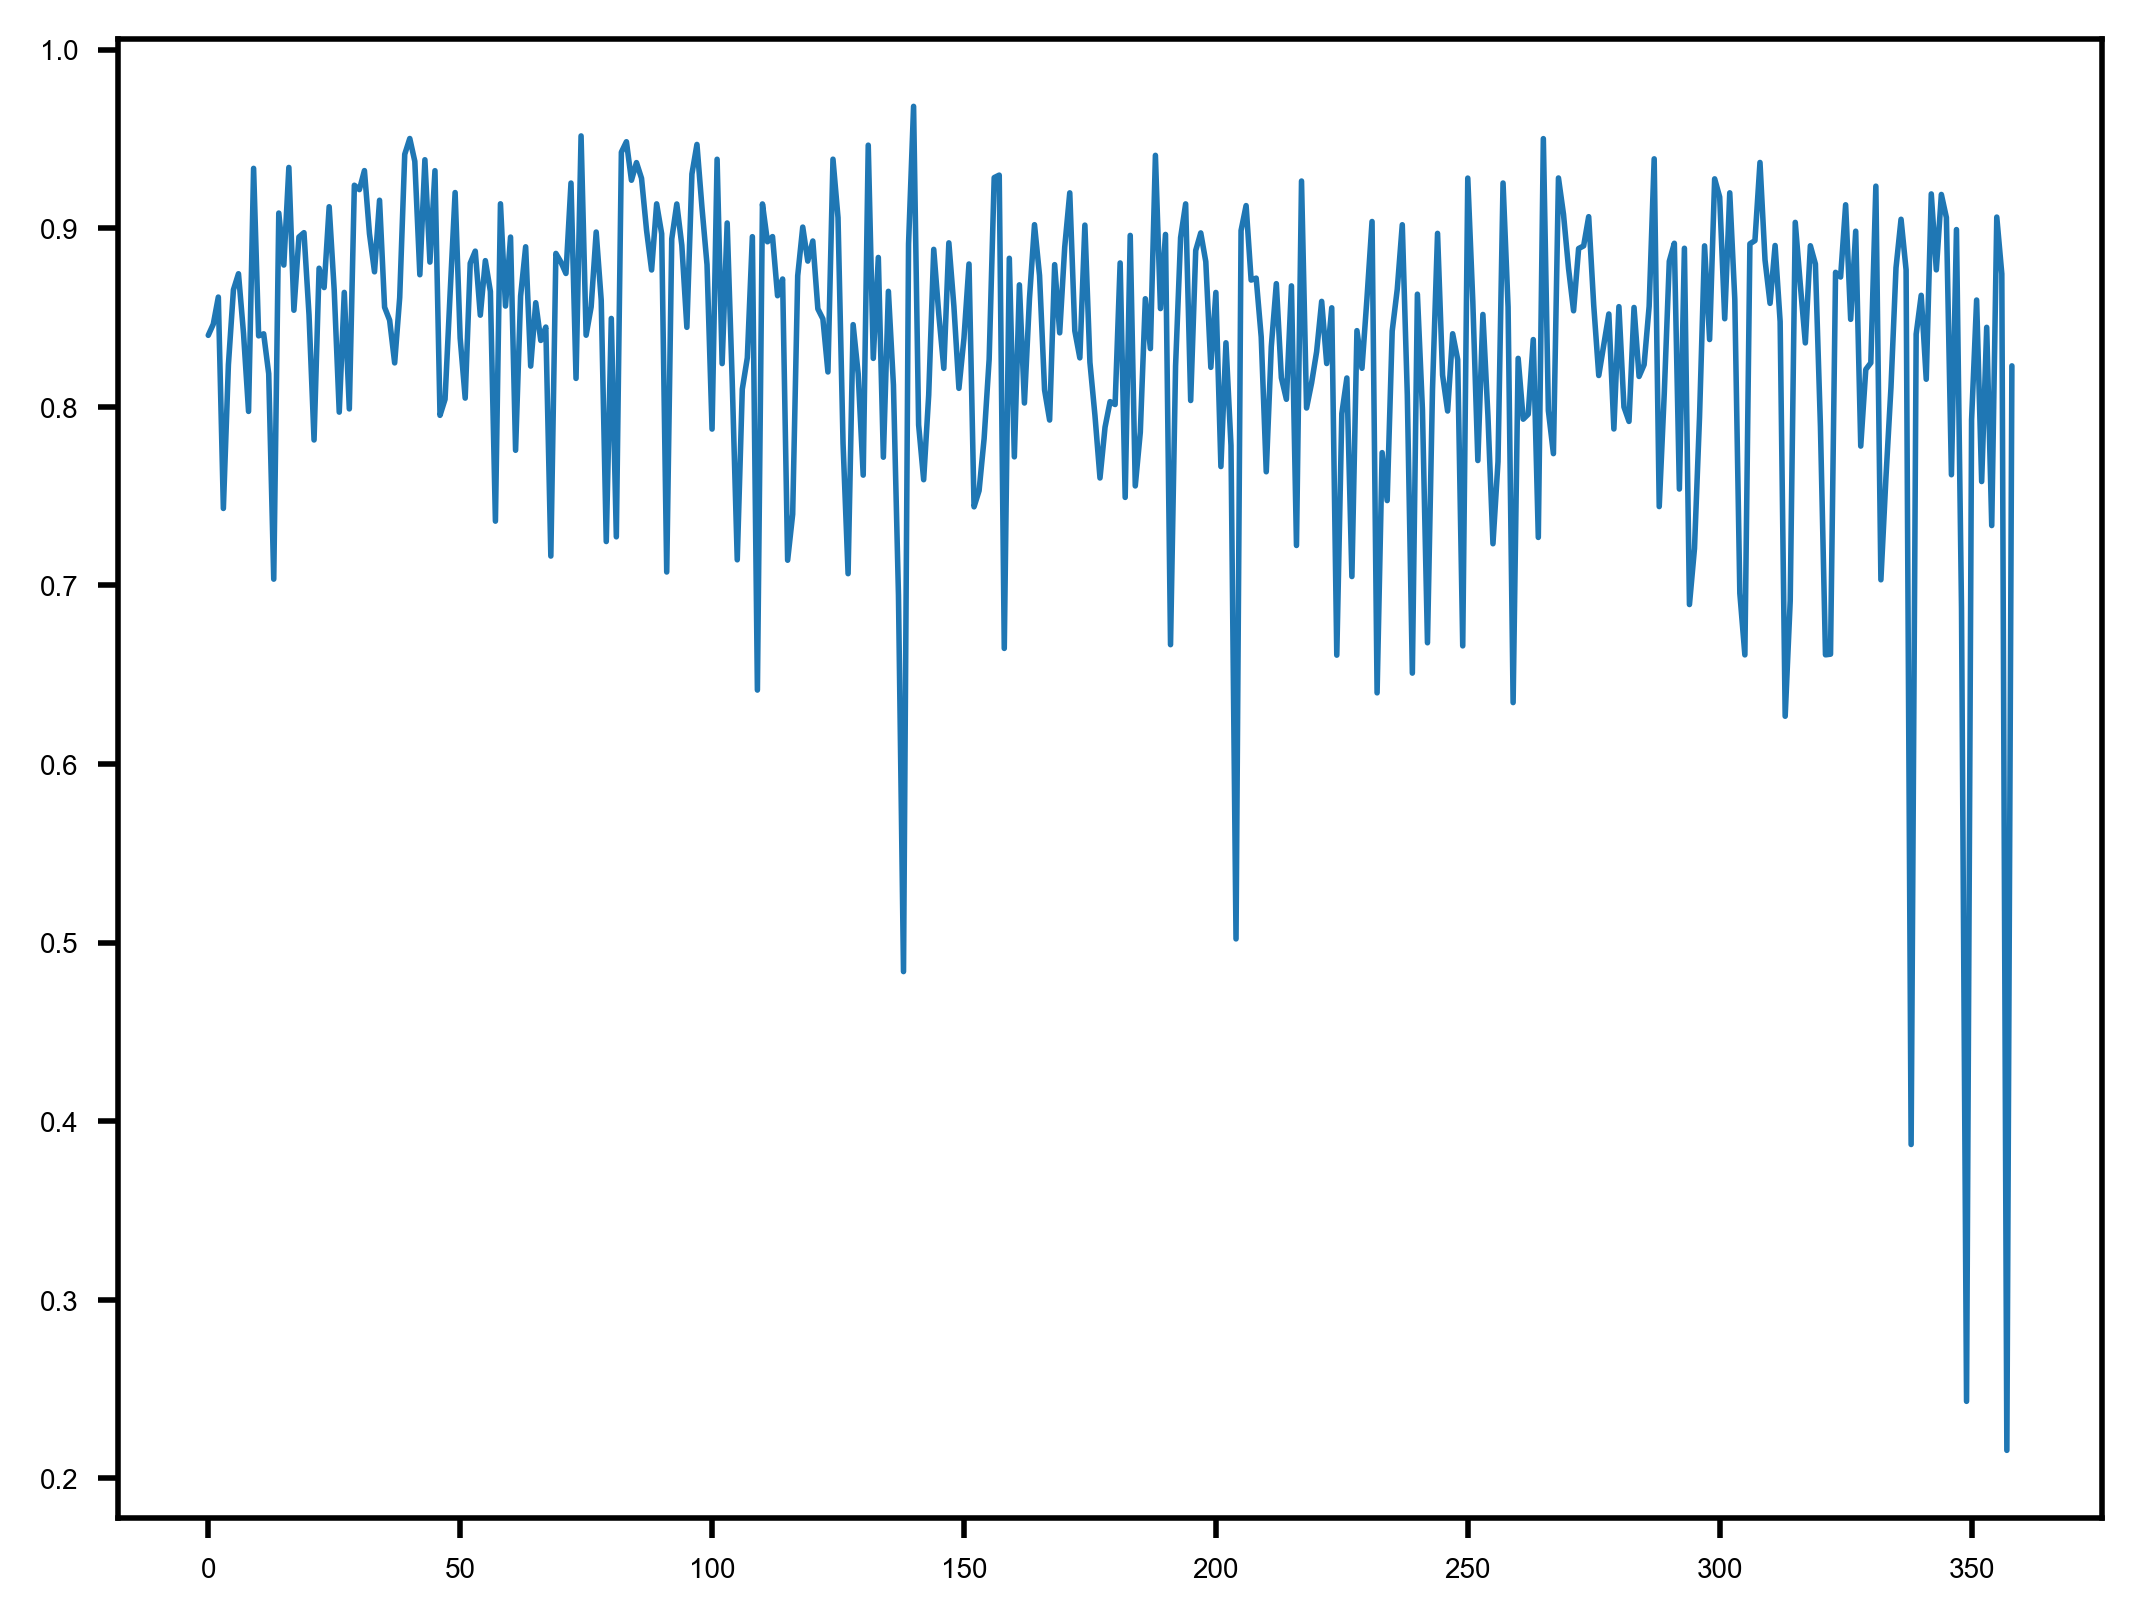

In [71]:
plt.plot(sliding_corr)

## Compute correlations for all 72-wk old animals

In [51]:
corrs = []
for file in tqdm(files):

    with h5py.File(file, 'r') as h5f:
        frames = h5f['frames'][()]
        recon_frames = h5f['win_size_norm_frames_v4'][()]
        before_scalars = {x: h5f['scalars'][f"{x}_mm"][()] for x in ("height_ave", "width", "length")}
        session_name = h5f['metadata/acquisition/SessionName'][()].decode()
    before_scalars = keymap(lambda k: k.split('_')[0], before_scalars)

    scalars = compute_scalars(
        np.array([clean(f, height_thresh=14, tail_ksize=7, dilation_ksize=4) for f in frames]),
        is_recon=False,
        height_thresh=10,
    )
    recon_scalars = compute_scalars(recon_frames, is_recon=False, height_thresh=10)

    tmp_corrs = {}
    for k, v in scalars.items():
        tmp_corrs[k] = pearsonr(np.nan_to_num(v), np.nan_to_num(recon_scalars[k]))[0]
    tmp_corrs['file'] = str(file)
    tmp_corrs['type'] = 'new'
    corrs.append(tmp_corrs)
    tmp_corrs = {}
    for k, v in before_scalars.items():
        tmp_corrs[k] = pearsonr(np.nan_to_num(v), np.nan_to_num(recon_scalars[k]))[0]
    tmp_corrs['file'] = str(file)
    tmp_corrs['type'] = 'old'
    tmp_corrs['session_name'] = session_name
    corrs.append(tmp_corrs)
corrs = pd.DataFrame(corrs)

  0%|          | 0/27 [00:00<?, ?it/s]

In [55]:
avgs = corrs.drop(columns=['area']).groupby(['file', 'type']).mean().mean(1)

In [56]:
avgs.groupby('type').mean()

type
new    0.864342
old    0.815640
dtype: float64

In [49]:
with h5py.File(file, 'r') as h5f:
    print(list(h5f['scalars']))

['angle', 'area_mm', 'area_px', 'centroid_x_mm', 'centroid_x_px', 'centroid_y_mm', 'centroid_y_px', 'height_ave_mm', 'length_mm', 'length_px', 'velocity_2d_mm', 'velocity_2d_px', 'velocity_3d_mm', 'velocity_3d_px', 'velocity_theta', 'width_mm', 'width_px']


In [60]:
with h5py.File(file, 'r') as h5f:
    print()

b'ontogeny_males_18months'


## All files

In [61]:
folder = Path('/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males')
files = sorted(folder.glob('**/results_00.h5'))

In [62]:
corrs = []
for file in tqdm(files):

    with h5py.File(file, 'r') as h5f:
        frames = h5f['frames'][()]
        recon_frames = h5f['win_size_norm_frames_v4'][()]
        session_name = h5f['metadata/acquisition/SessionName'][()].decode()

    scalars = compute_scalars(
        np.array([clean(f, height_thresh=14, tail_ksize=7, dilation_ksize=4) for f in frames]),
        is_recon=False,
        height_thresh=10,
    )
    recon_scalars = compute_scalars(recon_frames, is_recon=False, height_thresh=10)

    tmp_corrs = {}
    for k, v in scalars.items():
        tmp_corrs[k] = pearsonr(np.nan_to_num(v), np.nan_to_num(recon_scalars[k]))[0]
    tmp_corrs['file'] = str(file)
    tmp_corrs['session_name'] = session_name
    corrs.append(tmp_corrs)
corrs = pd.DataFrame(corrs)

  0%|          | 0/216 [00:00<?, ?it/s]

In [64]:
corrs.to_parquet('/n/groups/datta/win/longtogeny/data/metadata/dynamics-correlations.parquet')

In [65]:
corrs

,width,length,height,area,file,session_name
0,0.777147,0.910770,0.977018,0.791084,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_12months_28042021
1,0.836551,0.903028,0.967877,0.795368,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_12months_28042021
2,0.853410,0.944433,0.973683,0.852207,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_12months_28042021
3,0.683800,0.881641,0.961960,0.677327,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_12months_28042021
4,0.839354,0.927572,0.976681,0.830604,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_12months_28042021
...,...,...,...,...,...,...
211,0.876150,0.951648,0.950499,0.809595,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_cohorts_9wks
212,0.837809,0.945260,0.967134,0.837533,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogney_males_9w
213,0.877521,0.959848,0.966755,0.878248,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_9w
214,0.864527,0.959168,0.973509,0.885217,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_9w


In [67]:
corrs['avg'] = corrs[['width', 'length', 'height']].mean(1)

In [85]:
def age_map(age):
    if '12mo' in age:
        return 12 * 4
    if '18mo' in age:
        return 18 * 4
    if '6m' in age:
        return 6 * 4
    if '9mo' in age:
        return 9 * 4
    if '3m' in age:
        return 3 * 4
    if '3w' in age:
        return 3
    if '5w' in age:
        return 5
    if '7w' in age:
        return 7
    if '9w' in age:
        return 9
    if '90w' in age:
        return 90

In [94]:
corrs['age'] = corrs['session_name'].map(age_map)

In [87]:
corrs.loc[corrs['age'].isna()]

,width,length,height,area,file,session_name,avg,age
69,0.785289,0.934571,0.921815,0.757202,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.880558,NaN
70,0.823448,0.954023,0.963385,0.864511,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.913619,NaN
71,0.763350,0.931770,0.963013,0.843036,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.886044,NaN
72,0.773369,0.920207,0.956161,0.806356,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.883246,NaN
73,0.842185,0.955481,0.975601,0.879460,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.924422,NaN
74,0.797360,0.930083,0.956108,0.822887,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.894517,NaN
75,0.803642,0.938303,0.962336,0.786264,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.901427,NaN
76,0.775901,0.935445,0.973492,0.838495,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.894946,NaN
77,0.785048,0.926405,0.935385,0.815897,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.882279,NaN
78,0.850460,0.946916,0.975914,0.852421,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,ontogeny_males_22months_CRL,0.924430,NaN


In [88]:
corrs['age'].unique()

array([48., 72., 90., nan, 12.,  3.,  5., 24.,  7.,  9., 36.])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


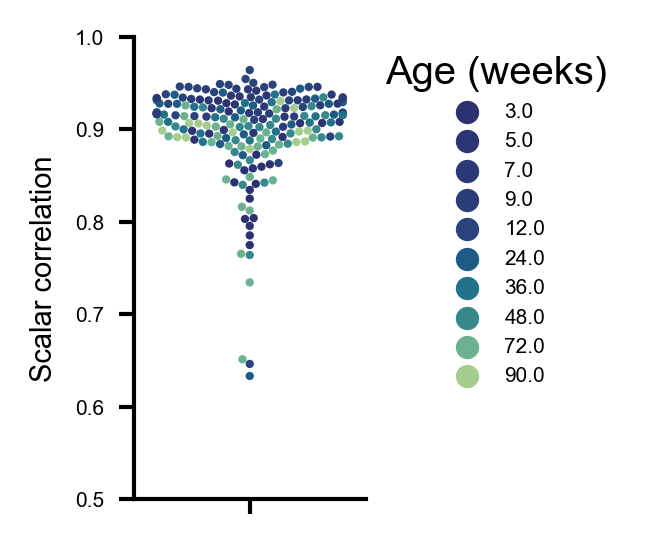

In [105]:
fig = figure(1, 2)
fig.dpi = 150
# sns.swarmplot(data=corrs, y='avg', hue='age', palette='crest_r', legend='full')
ax = sns.swarmplot(
    data=corrs,
    y="avg",
    hue="age",
    palette="crest_r",
    size=2,
    legend='full',
    # norm="log",
    # saturation=1,
)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left', title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel='Scalar correlation')
sns.despine()

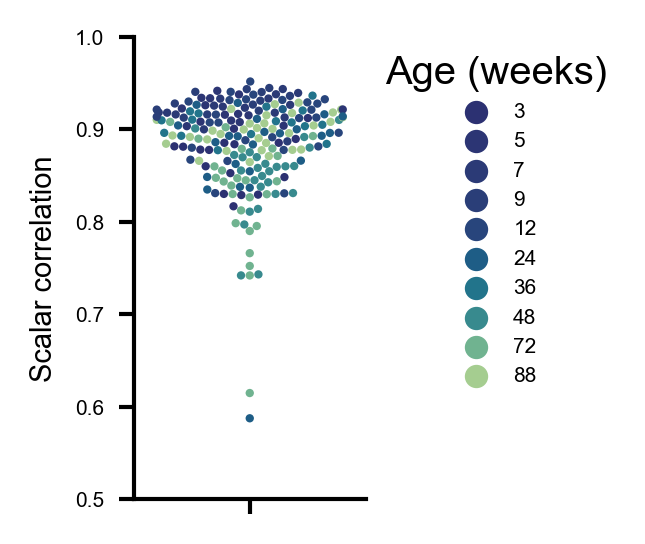

In [20]:
fig = plt.figure(figsize=(1, 2), dpi=150)
ax = sns.swarmplot(
    data=preserve_df,
    y="avg_corr",
    hue="age",
    palette="crest_r",
    size=2,
    legend='full',
    # norm="log",
    # saturation=1,
)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left', title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel='Scalar correlation')
sns.despine()
# saver(fig, 'correlation-vs-age-swarmplot');